# Higgs Analysis:

>This notebook contains work performed on coffea-casa cloud server. 
> Work in progress

In [250]:
from datetime import datetime
import pytz

ist = pytz.timezone('Asia/Kolkata')

print(f"Last modified: {datetime.now(ist).strftime('%d %B %Y, %H:%M')} IST")


Last modified: 17 October 2025, 19:39 IST


# Imports 

In [242]:
import os
import sys
import time
import gc
import psutil

# Data processing
import uproot
import awkward as ak
import numpy as np

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
# import mplhep as hep

# Numerical computing
import vector
import hist
from hist import Hist
from tqdm import tqdm

# Parallel processing 
import dask
from dask import delayed, compute
from dask.distributed import Client, LocalCluster
import dask.bag as db
from dask.diagnostics import ProgressBar

# others
# !pip install prettytable
from prettytable import PrettyTable

vector.register_awkward()

print(" All imports loaded")

 All imports loaded


# Setting up directory and files

In [174]:

print(f"Server: {os.uname().nodename}")
# Parallel processing
N_WORKERS = 9      

XROOTD_TIMEOUT = 600  # 10 minutes read timeout
XROOTD_MAX_RETRIES = 3  # Retry failed files 3 times
XROOTD_RETRY_WAIT = 10  # Wait 10 seconds between retries

print(f"Using {N_WORKERS} parallel workers")
print(f"XRootD timeout: {XROOTD_TIMEOUT}s ({XROOTD_TIMEOUT/60:.1f} min)")
print(f"Max retries: {XROOTD_MAX_RETRIES}")

# File paths
BASE_PATH = "/home/cms-jovyan/H-to-WW-NanoAOD-analysis/Datasets"
DATA_DIR = os.path.join(BASE_PATH, "DATA")
MC_DIR = os.path.join(BASE_PATH, "MC_samples")

# LOAD FILE URLS

def load_urls_from_file(filepath, max_files=None):
    """Load XRootD URLs from text file"""
    urls = []
    if not os.path.exists(filepath):
        return urls
    
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line and line.startswith('root://'):
                urls.append(line)
                if max_files and len(urls) >= max_files:
                    break
    return urls

def load_all_files(data_dir, mc_dir, max_per_sample=None):
    """Load all file URLs from directories"""
    
    files_dict = {}
    
    
    mapping = {
        # Data 
        'data': 'Data',      
        # MC samples
        'higgs': 'signal',
        'dytoll': 'DY_to_Tau_Tau',      # DYtoLL.txt
        'top': 'Top_antitop',            # Top.txt
        'fakes': 'Fakes',                # Fakes.txt
        'vz': 'Diboson',                 # VZ.txt(Diboson)
        'ggww': 'ggWW',                  # ggWW.txt
        'ww': 'WW',                      # WW.txt 
        'vg': 'VG'                       # VG.txt
    }
    
    for directory in [data_dir, mc_dir]:
        if not os.path.exists(directory):
            continue
            
        for filename in os.listdir(directory):
            if not filename.endswith(('.txt')):
                continue
                
            filepath = os.path.join(directory, filename)
            filename_lower = filename.lower().replace('.txt', '')
            
            # Find label
            label = None
            for pattern, sample_label in mapping.items():
                if pattern in filename_lower:
                    label = sample_label
                    break
            
            if not label:
                print(f"   Unknown file: {filename} - skipping")
                continue
            
            # Load URLs
            urls = load_urls_from_file(filepath, max_per_sample)
            
            if urls:
                if label in files_dict:
                    files_dict[label].extend(urls)
                else:
                    files_dict[label] = urls
    
    return files_dict
    

# files = load_all_files(DATA_DIR, MC_DIR, max_per_sample=10)  # TESTING
files = load_all_files(DATA_DIR, MC_DIR)  # FULL 

print("\n" + "="*70)
print("FILES TO PROCESS")
print("="*70)
total = 0
for label, urls in files.items():
    print(f"{label:20s}: {len(urls):4d} files")
    total += len(urls)
print("_"*70)
print(f"{'TOTAL':20s}: {total:4d} files")
print("="*70)

Server: jupyter-anujraghav-2ephysics-40gmail-2ecom
Using 9 parallel workers
XRootD timeout: 600s (10.0 min)
Max retries: 3

FILES TO PROCESS
Data                :   29 files
VG                  :   32 files
signal              :   40 files
WW                  :    7 files
Fakes               :  206 files
Diboson             :   73 files
DY_to_Tau_Tau       :   61 files
ggWW                :  112 files
Top_antitop         :  197 files
______________________________________________________________________
TOTAL               :  757 files


In [251]:
SAMPLES = {
    "signal": {
        "color": "#E41A1C",  
        "is_signal": True,
        "stack_order": None
    },
    "DY_to_Tau_Tau": {
        "color": "#33A02C",  
        "is_signal": False,
        "stack_order": 0  
    },
    "Diboson": {
        "color": "#A6CEE3",  
        "is_signal": False,
        "stack_order": 1  
    },
    "VG": {
        "color": "#FFCC00", 
        "is_signal": False,
        "stack_order": 2 
    },
    "WW": {
        "color": "#1F78B4",  
        "is_signal": False,
        "stack_order": 3  
    },
    "Top_antitop": {
        "color": "#FF7F00",  
        "is_signal": False,
        "stack_order": 4  
    },
    "ggWW": {
        "color": "#6BAED6",  
        "is_signal": False,
        "stack_order": 5  
    },
    "Fakes": {
        "color": "#B3B3B3",  
        "is_signal": False,
        "stack_order": 6 
    },
    "Data": {
        "color": "#000000",  
        "is_signal": False,
        "stack_order": None
    }
}

colors = {key: value["color"] for key, value in SAMPLES.items()}

## Loading branches to use 

In [252]:
def load_events(file_url, batch_size=50_000, timeout=600, max_retries=3, retry_wait=10):

    
    columns = [
        "Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", 
        "Electron_mvaFall17V2Iso_WP90", "Electron_charge",
        
        "Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", 
        "Muon_tightId", "Muon_charge", "Muon_pfRelIso04_all",
        "MET_pt", "MET_phi",
        
        "Jet_pt", "Jet_eta", "Jet_phi", "Jet_mass",
        "Jet_btagDeepFlavB", "nJet", "Jet_jetId", "Jet_puId",
    ]
    
    for attempt in range(max_retries):
        try:
            
            with uproot.open(file_url, timeout=timeout, num_workers=1) as f:
                tree = f['Events']
                
                
                for arrays in tree.iterate(columns, step_size=batch_size, library="ak"):
                    yield arrays
                
               
                return
                
        except (TimeoutError, OSError, IOError, ConnectionError) as e:
            error_type = type(e).__name__
            file_name = file_url.split('/')[-1]
            
            if attempt < max_retries - 1:
                print(f"      {error_type} on {file_name}")
                print(f"       Retry {attempt+1}/{max_retries-1} in {retry_wait}s...")
                time.sleep(retry_wait)
            else:
                print(f"     FAILED after {max_retries} attempts: {file_name}")
                print(f"       Error: {str(e)[:100]}")
                raise
                
        except Exception as e:
            
            file_name = file_url.split('/')[-1]
            print(f"     Unexpected error on {file_name}: {str(e)[:100]}")
            raise

## Helper functions

In [106]:
# %%
def wrap_angle_to_pi(angle):
    """More concise way to wrap angle to [-π, π] range"""
    return (angle + np.pi) % (2 * np.pi) - np.pi

def create_lepton_vector(lepton):
    """Create 4-vector from lepton properties - unified function"""
    return vector.array({
        "pt": lepton.pt,
        "eta": lepton.eta,
        "phi": lepton.phi,
        "mass": lepton.mass
    })

## Selecting tight leptons (Electrons and Muon)

In [107]:

# %%
def select_tight_leptons(arrays):
    """Apply tight ID and isolation cuts to leptons"""
    # Define selection masks
    tight_electron_mask = arrays.Electron_mvaFall17V2Iso_WP90 == 1
    tight_muon_mask = (arrays.Muon_tightId == 1) & (arrays.Muon_pfRelIso04_all < 0.15)
    
    # Create structured arrays for selected leptons
    tight_electrons = ak.zip({
        "pt": arrays.Electron_pt[tight_electron_mask],
        "eta": arrays.Electron_eta[tight_electron_mask],
        "phi": arrays.Electron_phi[tight_electron_mask],
        "mass": arrays.Electron_mass[tight_electron_mask],
        "charge": arrays.Electron_charge[tight_electron_mask],
        "flavor": ak.ones_like(arrays.Electron_pt[tight_electron_mask]) * 11
    })
    
    tight_muons = ak.zip({
        "pt": arrays.Muon_pt[tight_muon_mask],
        "eta": arrays.Muon_eta[tight_muon_mask],
        "phi": arrays.Muon_phi[tight_muon_mask],
        "mass": arrays.Muon_mass[tight_muon_mask],
        "charge": arrays.Muon_charge[tight_muon_mask],
        "flavor": ak.ones_like(arrays.Muon_pt[tight_muon_mask]) * 13
    })
    
    # Combine into single collection
    tight_leptons = ak.concatenate([tight_electrons, tight_muons], axis=1)
    
    return tight_leptons, tight_electron_mask, tight_muon_mask

In [108]:
def select_e_mu_events(tight_leptons, met_arrays, leading_pt_cut=25, subleading_pt_cut=15):
    """Select events with exactly 1 electron and 1 muon"""
    
    # Sort by pT
    sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
    
    # Require at least 2 leptons
    mask_2lep = ak.num(sorted_leptons) == 2
    events_2lep = sorted_leptons[mask_2lep]
    met_2lep = met_arrays[mask_2lep]
    
    if len(events_2lep) == 0:
        return None, None, {}, None
    
    # Get leading and subleading
    leading = events_2lep[:, 0]
    subleading = events_2lep[:, 1]
    
    # Selection criteria
    mask_1e1mu = ((leading.flavor == 11) & (subleading.flavor == 13)) | \
                 ((leading.flavor == 13) & (subleading.flavor == 11))
    mask_opposite_charge = leading.charge * subleading.charge < 0
    mask_pt = (leading.pt > leading_pt_cut) & (subleading.pt > subleading_pt_cut)
    
    # Final selection
    final_mask = mask_1e1mu & mask_opposite_charge & mask_pt
    
    # Store cutflow information
    cutflow = {
        'events_2lep': len(leading),
        'events_1e1mu': ak.sum(mask_1e1mu),
        'events_opposite_charge': ak.sum(mask_1e1mu & mask_opposite_charge),
        'events_final': ak.sum(final_mask)
    }
    
    return leading[final_mask], subleading[final_mask], cutflow, met_2lep[final_mask]


## Calculating  kinematic variables 
- Invariant mass of dilepton(electron and muon) system
- Transverse momentum of dilepton system
- Azimuathal seperation between dileptons
- Transverse mass of Higgs
- Transvers mass of subleading lepton and $E^T_{miss}$ 
  

In [109]:
def cal_kinematic_var(leading, subleading, met):

    lepton_1 = create_lepton_vector(leading)
    lepton_2 = create_lepton_vector(subleading)


    dilepton = lepton_1 + lepton_2

    masses = dilepton.mass
    ptll = dilepton.pt
    dphi = wrap_angle_to_pi(leading.phi - subleading.phi)


    mt_higgs_dphi = wrap_angle_to_pi(dilepton.phi - met.phi)
    mt_higgs = np.sqrt(2 * dilepton.pt * met.pt * (1 - np.cos(mt_higgs_dphi)))

    mt_l2_met_dphi = wrap_angle_to_pi(subleading.phi - met.phi)
    mt_l2_met = np.sqrt(2 * subleading.pt * met.pt * (1 - np.cos(mt_l2_met_dphi)))


    return masses, ptll, dphi, mt_higgs, mt_l2_met


## Calculating Invriant mass of jets and applying $m_{jj}$

In [110]:
def calculate_mjj(jets):
    """Calculate invariant mass of the two leading jets.
    
    Assumes jets are already sorted by pT (descending).
    Returns 0 for events with < 2 jets.
    """
    # Get number of jets per event
    n_jets = ak.num(jets)
    
    # Initialize mjj with zeros for all events
    mjj = ak.zeros_like(n_jets, dtype=float)
    
    # Create mask for events with at least 2 jets
    has_two_jets = n_jets >= 2
    
    # Only proceed if there are events with 2+ jets
    if ak.any(has_two_jets):
        # Use padding to safely access indices
        jets_padded = ak.pad_none(jets, 2, axis=1)
        
        # Create 4-vectors for jets
        jet_vectors = ak.zip({
            "pt": ak.fill_none(jets_padded.pt, 0.0),
            "eta": ak.fill_none(jets_padded.eta, 0.0),
            "phi": ak.fill_none(jets_padded.phi, 0.0),
            "mass": ak.fill_none(jets_padded.mass, 0.0)
        }, with_name="Momentum4D")
        
        # Get first two jets
        jet1 = jet_vectors[:, 0]
        jet2 = jet_vectors[:, 1]
        
        # Calculate invariant mass using vector addition
        dijet = jet1 + jet2
        mjj_calculated = dijet.mass
        
        # Apply only where we have 2+ jets
        mjj = ak.where(has_two_jets, mjj_calculated, 0.0)
    
    return mjj

def apply_mjj_window(mjj):
    return (mjj < 65) | ((mjj > 105) & (mjj < 120))

## 

## Counting jets and 0/1/2 Jet categorisation

In [111]:

def count_jets(arrays, jet_pt_threshold=30, tight_leptons = None):
   

    # Step 1: Create Jet object from individual arrays
    jets = ak.zip({
        "pt": arrays.Jet_pt,
        "eta": arrays.Jet_eta,
        "phi": arrays.Jet_phi,
        "mass": arrays.Jet_mass,
        "jetId": arrays.Jet_jetId,
        "btagDeepFlavB": arrays.Jet_btagDeepFlavB,
        "Jet_puId": arrays.Jet_puId
    })
    
    # Step 2: Good jet selection (Tight ID AND pt above threshold)
    pu_id_mask = (jets.pt > 50) | ((jets.pt <= 50) & (jets.Jet_puId >= 4))
    good_mask = (jets.jetId >= 2) & (abs(jets.phi)<4.7) & pu_id_mask
  
    if tight_leptons is None or ak.max(ak.num(tight_leptons)) == 0:
        return good_mask
    
    #  compute delta R between jets and leptons
    try:
        jets_eta = jets.eta[:, :, None]       
        jets_phi = jets.phi[:, :, None]
        leps_eta = tight_leptons.eta[:, None, :] 
        leps_phi = tight_leptons.phi[:, None, :]
        
        deta = jets_eta - leps_eta
        dphi = (jets_phi - leps_phi + np.pi) % (2*np.pi) - np.pi
        dr = np.sqrt(deta**2 + dphi**2)
        
        # Minimum delta R over all leptons for each jet
        min_dr = ak.min(dr, axis=-1)
        
        # Jets passing the delta R cut
        dr_cut_mask = min_dr > 0.4
        
        # Update good_mask
        good_mask = good_mask & dr_cut_mask
    
    except Exception as e:
        print(f"Warning: Lepton cleaning failed ({e}), skipping...")

    good_jets = jets[good_mask]
    
    # Step 3: Sort by pt
    order = ak.argsort(good_jets.pt, axis=1, ascending=False)
    sorted_jets = good_jets[order]

    lead_jet_pt = ak.fill_none(ak.firsts(sorted_jets.pt),0)
    sublead_jet_pt = ak.fill_none(ak.firsts(sorted_jets.pt[..., 1:]), 0)

    # Step 4: Calculate mjj
    mjj = calculate_mjj(sorted_jets)

    # Step 5: Category masks based on jet count  
    isZeroJet = (lead_jet_pt < jet_pt_threshold)
    isOneJet = (lead_jet_pt >= jet_pt_threshold) & (sublead_jet_pt < jet_pt_threshold)
    isTwoJet = (sublead_jet_pt >= jet_pt_threshold) & apply_mjj_window(mjj)

    n_jets = ak.sum(sorted_jets.pt >= jet_pt_threshold, axis = 1)

    return n_jets, good_mask, sorted_jets, isZeroJet, isOneJet, isTwoJet
    

In [112]:
def get_bjet_categories(arrays, btag_threshold=0.2217, eta_max=2.5):
    """
    Get different b-jet categories needed for SR/CR selection.
    """
    # Base b-jet selection 
    base_bjet_mask = (
        (arrays.Jet_jetId >= 2) &
        (abs(arrays.Jet_eta) < eta_max) &
        (arrays.Jet_btagDeepFlavB > btag_threshold)
    )
    
    # Different pT categories
    bjets_20 = base_bjet_mask & (arrays.Jet_pt > 20)
    bjets_20_30 = base_bjet_mask & (arrays.Jet_pt > 20) & (arrays.Jet_pt <= 30)
    bjets_30 = base_bjet_mask & (arrays.Jet_pt > 30)
    
    # Count per event
    n_bjets_20 = ak.sum(bjets_20, axis=1)
    n_bjets_20_30 = ak.sum(bjets_20_30, axis=1) 
    n_bjets_30 = ak.sum(bjets_30, axis=1)
    
    return {
        # For Signal Regions 
        'passes_bjet_veto': n_bjets_20 == 0,  
        
        # For Control Regions
        'has_btag_20_30': n_bjets_20_30 > 0,  # Top CR 0-jet
        'has_btag_30': n_bjets_30 > 0,        # Top CR 1-jet, 2-jet
        
        # Counts
        'n_bjets_20': n_bjets_20,
        'n_bjets_20_30': n_bjets_20_30,
        'n_bjets_30': n_bjets_30
    }


def apply_bjet_selections(arrays):
   
    bjet_info = get_bjet_categories(arrays)
    
    # For Signal Regions
    sr_bjet_veto = bjet_info['passes_bjet_veto']
    
    # For Control Regions
    cr_top_0jet = bjet_info['has_btag_20_30']
    cr_top_1jet_2jet = bjet_info['has_btag_30']
    
    return sr_bjet_veto, bjet_info

## Defining Signal & Control region

In [113]:
def apply_signal_region_cuts(leading, subleading, met, masses, ptlls, mt_higgs, 
                           mt_l2_met, isZeroJet, isOneJet, isTwoJet, 
                           bjet_veto_mask, mjj=None):
    """Apply Signal Region selections for all jet categories."""
    
    # Base global selection for Signal Regions
    sr_base = (
        (leading.pt > 25) & 
        (subleading.pt > 15) &  
        (met.pt > 20) &
        (ptlls > 30) &
        (masses > 12) &
        (mt_l2_met > 30) &
        (subleading.pt <= 20) &  
        (mt_higgs > 60) &        # SR mt_higgs cut
        bjet_veto_mask           # No b-jets for SR
    )
    
    # Apply mjj window for 2-jet category
    if mjj is not None:
        mjj_window = apply_mjj_window(mjj)
    else:
        mjj_window = ak.ones_like(isTwoJet, dtype=bool)
    
    sr_regions = {
        'SR_0jet': sr_base & isZeroJet,
        'SR_1jet': sr_base & isOneJet,
        'SR_2jet': sr_base & isTwoJet & mjj_window
    }
    
    return sr_regions


In [114]:
def apply_control_region_cuts(leading, subleading, met, masses, ptlls, mt_higgs, 
                            mt_l2_met, isZeroJet, isOneJet, isTwoJet, 
                            bjet_info, mjj=None):
    """Apply Control Region selections for all jet categories."""
    
    # Base global selection for Control Regions
    cr_base = (
        (leading.pt > 25) & 
        (subleading.pt > 15) &
        (met.pt > 20) &
        (ptlls > 30) &
        (masses > 12) &
        (mt_l2_met > 30) &
        (subleading.pt <= 20)
    )
    
    # Apply mjj window for 2-jet category
    if mjj is not None:
        mjj_window = apply_mjj_window(mjj)
    else:
        mjj_window = ak.ones_like(isTwoJet, dtype=bool)
    
    cr_regions = {}
    
    # === TOP CONTROL REGIONS ===
    cr_top_base = cr_base & (masses > 50)
    
    cr_regions['CR_top_0jet'] = (
        cr_top_base & 
        isZeroJet & 
        bjet_info['has_btag_20_30']  # 20 < pT < 30 GeV b-jets for 0-jet
    )
    
    cr_regions['CR_top_1jet'] = (
        cr_top_base & 
        isOneJet & 
        bjet_info['has_btag_30']     # pT > 30 GeV b-jets for 1-jet
    )
    
    cr_regions['CR_top_2jet'] = (
        cr_top_base & 
        isTwoJet & 
        mjj_window &
        bjet_info['has_btag_30']     # pT > 30 GeV b-jets for 2-jet
    )
    
    # === TAU-TAU CONTROL REGIONS ===
    cr_tau_base = (
        cr_base & 
        (mt_higgs < 60) & 
        (masses > 40) & 
        (masses < 80) &
        bjet_info['passes_bjet_veto']  
    )
    
    cr_regions['CR_tau_0jet'] = cr_tau_base & isZeroJet
    cr_regions['CR_tau_1jet'] = cr_tau_base & isOneJet  
    cr_regions['CR_tau_2jet'] = cr_tau_base & isTwoJet & mjj_window
    
    return cr_regions

## Global cuts 

In [115]:
def apply_global_cuts(leading, subleading, met, mt_higgs, mt_l2_met,ptlls,masses):
    """Apply global selection cuts"""
    # Global cuts
    mask_subleading_pt = subleading.pt >= 15 
    mask_mt_higgs = mt_higgs > 60
    mask_mt_l2_met = mt_l2_met > 30
    mask_met_pt = met.pt > 20
    mask_ptll  = ptlls > 30
    mask_mll = masses > 12 
    
    # Combine all masks
    global_mask = mask_mt_higgs & mask_mt_l2_met & mask_subleading_pt & mask_met_pt & mask_ptll & mask_mll

    return global_mask, {
        'pass_mt_higgs': ak.sum(mask_mt_higgs),
        'pass_mt_l2_met': ak.sum(mask_mt_l2_met),
        'pass_subleading_pt': ak.sum(mask_subleading_pt),
        'pass_met_pt': ak.sum(mask_met_pt),
        'pass_ptll': ak.sum(mask_ptll),
        'pass_mll': ak.sum(mask_mll),
        'pass_global': ak.sum(global_mask)
    }

In [177]:
def initialize_stage_histograms():
    """Initialize histograms for all selection stages"""
    
    # Define binning
    bins = {
        'mass': hist.axis.Regular(50, 0, 200, name="mass", label="m_ll [GeV]"),
        'met': hist.axis.Regular(50, 0, 200, name="met", label="MET [GeV]"),
        'dphi': hist.axis.Regular(50, 0, np.pi, name="dphi", label="dphi(l,l)"),
        'ptll': hist.axis.Regular(50, 0, 200, name="ptll", label="p_T^ll [GeV]"),
        'mt_higgs': hist.axis.Regular(50, 0, 300, name="mt_higgs", label="m_T^H [GeV]"),
        'mt_l2_met': hist.axis.Regular(50, 0, 200, name="mt_l2_met", label="m_T(l2,MET) [GeV]"),
        'mjj': hist.axis.Regular(50, 0, 500, name="mjj", label="m_jj [GeV]"),
        'leading_pt': hist.axis.Regular(50, 0, 200, name="leading_pt", label="Leading lepton p_T [GeV]"),
        'subleading_pt': hist.axis.Regular(50, 0, 200, name="subleading_pt", label="Subleading lepton p_T [GeV]"),
    }
    
    stage_names = [
        'before_cuts', 'global', '0jet', '1jet', '2jet',
        'SR_0jet', 'SR_1jet', 'SR_2jet',
        'CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet',
        'CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet'
    ]
    
    stage_histograms = {}
    for stage in stage_names:
        stage_histograms[stage] = {
            var_name: Hist(axis) for var_name, axis in bins.items()
        }
    
    return stage_histograms

# Initialize for all samples
hist_data = {}
for label in ['Data', 'signal', 'DY_to_Tau_Tau', 'Top_antitop', 'Fakes', 
              'Diboson', 'ggWW', 'WW', 'VG']:
    hist_data[label] = initialize_stage_histograms()

print("Histogram storage initialized")

Histogram storage initialized


## Processing function

In [117]:
def process_sample_dask(label, file_urls, position):
    """Process all files with histogram-based storage (memory efficient)"""
    try:
        # Monitor memory
        process = psutil.Process(os.getpid())
        start_mem = process.memory_info().rss / (1024**3)
        start_time_sample = time.time()
        
        print(f"[Worker {position}] Starting: {label} ({len(file_urls)} files) - RAM: {start_mem:.1f}GB")
        
        # Initialize local histograms (will be merged at end)
        stage_histograms = initialize_stage_histograms()
        
        cutflow = {stage: 0 for stage in ['total', 'e_mu_preselection', 'global_cuts'] + 
                   ['0jet', '1jet', '2jet'] +
                   ['SR_0jet', 'SR_1jet', 'SR_2jet'] +
                   ['CR_top_0jet', 'CR_top_1jet', 'CR_top_2jet'] +
                   ['CR_tau_0jet', 'CR_tau_1jet', 'CR_tau_2jet']}
        
        # Process each file
        for file_idx, file_url in enumerate(file_urls):
            file_name = file_url.split('/')[-1]
            
            # Progress reporting every 5 files
            if file_idx % 5 == 0 or file_idx == len(file_urls) - 1:
                current_mem = process.memory_info().rss / (1024**3)
                mem_delta = current_mem - start_mem
                elapsed = time.time() - start_time_sample
                print(f"[Worker {position}] {label}: File {file_idx+1}/{len(file_urls)} "
                      f"- RAM: {current_mem:.1f}GB (+{mem_delta:.1f}GB) - {elapsed/60:.1f}min")
            
            try:
            
                for arrays in load_events(
                    file_url,
                    batch_size=50_000,
                    timeout=XROOTD_TIMEOUT,
                    max_retries=XROOTD_MAX_RETRIES,
                    retry_wait=XROOTD_RETRY_WAIT
                ):
                    cutflow['total'] += len(arrays)
                    
                    # Get tight leptons
                    tight_leptons, _, _ = select_tight_leptons(arrays)
                    met = ak.zip({"pt": arrays.MET_pt, "phi": arrays.MET_phi})
                    
                    # Apply e-mu selection
                    leading, subleading, emu_cutflow, met_selected = select_e_mu_events(tight_leptons, met)
                    
                    if leading is None or len(leading) == 0:
                        continue
                        
                    cutflow['e_mu_preselection'] += len(leading)
                    
                    # Calculate kinematic variables
                    masses, ptlls, dphis, mt_higgs, mt_l2_met = cal_kinematic_var(leading, subleading, met_selected)
                    
                    mjj_before = ak.zeros_like(masses)
                    
                    # Fill before_cuts histograms
                    stage_histograms['before_cuts']['mass'].fill(ak.to_numpy(masses))
                    stage_histograms['before_cuts']['met'].fill(ak.to_numpy(met_selected.pt))
                    stage_histograms['before_cuts']['dphi'].fill(ak.to_numpy(dphis))
                    stage_histograms['before_cuts']['ptll'].fill(ak.to_numpy(ptlls))
                    stage_histograms['before_cuts']['mt_higgs'].fill(ak.to_numpy(mt_higgs))
                    stage_histograms['before_cuts']['mt_l2_met'].fill(ak.to_numpy(mt_l2_met))
                    stage_histograms['before_cuts']['mjj'].fill(ak.to_numpy(mjj_before))
                    stage_histograms['before_cuts']['leading_pt'].fill(ak.to_numpy(leading.pt))
                    stage_histograms['before_cuts']['subleading_pt'].fill(ak.to_numpy(subleading.pt))
                    
                    # Global cuts and jet counting
                    sorted_leptons = tight_leptons[ak.argsort(tight_leptons.pt, ascending=False)]
                    has_2lep = ak.num(sorted_leptons) == 2
                    
                    events_2lep = sorted_leptons[has_2lep]
                    if len(events_2lep) > 0:
                        lead_all = events_2lep[:, 0]
                        sublead_all = events_2lep[:, 1]
                        
                        mask_1e1mu = ((lead_all.flavor == 11) & (sublead_all.flavor == 13)) | \
                                     ((lead_all.flavor == 13) & (sublead_all.flavor == 11))
                        mask_charge = lead_all.charge * sublead_all.charge < 0
                        mask_pt = (lead_all.pt > 25) & (sublead_all.pt > 15)
                        
                        emu_mask_2lep = mask_1e1mu & mask_charge & mask_pt
                        
                        indices_2lep = ak.where(has_2lep)[0]
                        indices_emu = indices_2lep[emu_mask_2lep]

                        n_jets_full, _, sorted_jets_full, isZeroJet_full, isOneJet_full, isTwoJet_full = count_jets(
                            arrays, tight_leptons=tight_leptons
                        )
                        mjj_full = calculate_mjj(sorted_jets_full)
                        mjj_selected = mjj_full[indices_emu]
                        mjj_selected = ak.fill_none(mjj_selected, 0.0)
                        
                        global_cut_mask, _ = apply_global_cuts(leading, subleading, met_selected, mt_higgs, mt_l2_met, ptlls, masses)
                        bjet_veto_full, bjet_info_full = apply_bjet_selections(arrays)
                        bjet_veto_selected = bjet_veto_full[indices_emu]
                        bjet_info_selected = {key: value[indices_emu] for key, value in bjet_info_full.items()}
                        
                        global_mask_selected = global_cut_mask & bjet_veto_selected
                        cutflow['global_cuts'] += ak.sum(global_mask_selected)
                        
                        if ak.sum(global_mask_selected) > 0:
                            # Fill global histograms
                            def fill_histograms(stage_name, mask):
                                if ak.sum(mask) > 0:
                                    stage_histograms[stage_name]['mass'].fill(ak.to_numpy(masses[mask]))
                                    stage_histograms[stage_name]['met'].fill(ak.to_numpy(met_selected.pt[mask]))
                                    stage_histograms[stage_name]['dphi'].fill(ak.to_numpy(dphis[mask]))
                                    stage_histograms[stage_name]['ptll'].fill(ak.to_numpy(ptlls[mask]))
                                    stage_histograms[stage_name]['mt_higgs'].fill(ak.to_numpy(mt_higgs[mask]))
                                    stage_histograms[stage_name]['mt_l2_met'].fill(ak.to_numpy(mt_l2_met[mask]))
                                    stage_histograms[stage_name]['mjj'].fill(ak.to_numpy(mjj_selected[mask]))
                                    stage_histograms[stage_name]['leading_pt'].fill(ak.to_numpy(leading.pt[mask]))
                                    stage_histograms[stage_name]['subleading_pt'].fill(ak.to_numpy(subleading.pt[mask]))
                            
                            fill_histograms('global', global_mask_selected)
                            
                            isZeroJet_selected = isZeroJet_full[indices_emu]
                            isOneJet_selected = isOneJet_full[indices_emu]
                            isTwoJet_selected = isTwoJet_full[indices_emu]

                            mask_0jet = global_mask_selected & isZeroJet_selected
                            mask_1jet = global_mask_selected & isOneJet_selected
                            mask_2jet = global_mask_selected & isTwoJet_selected

                            cutflow['0jet'] += ak.sum(mask_0jet)
                            cutflow['1jet'] += ak.sum(mask_1jet)
                            cutflow['2jet'] += ak.sum(mask_2jet)

                            fill_histograms('0jet', mask_0jet)
                            fill_histograms('1jet', mask_1jet)
                            fill_histograms('2jet', mask_2jet)
                            
                            # Signal and Control Regions
                            sr_regions = apply_signal_region_cuts(
                                leading, subleading, met_selected, masses, ptlls, mt_higgs,
                                mt_l2_met, isZeroJet_selected, isOneJet_selected, isTwoJet_selected,
                                bjet_veto_selected, mjj_selected
                            )
                            
                            cr_regions = apply_control_region_cuts(
                                leading, subleading, met_selected, masses, ptlls, mt_higgs,
                                mt_l2_met, isZeroJet_selected, isOneJet_selected, isTwoJet_selected,
                                bjet_info_selected, mjj_selected
                            )
                            
                            all_regions = {**sr_regions, **cr_regions}
                            
                            for region_name, region_mask in all_regions.items():
                                cutflow[region_name] += ak.sum(region_mask)
                                fill_histograms(region_name, region_mask)
                    
                    # Clear memory 
                    del arrays
                    gc.collect()
                
            except Exception as e:
                print(f"[Worker {position}]   Skipping {file_name}: {str(e)[:80]}")
                continue
            
            # garbage collection 
            gc.collect()
        
    
        end_mem = process.memory_info().rss / (1024**3)
        elapsed = time.time() - start_time_sample
        print(f"[Worker {position}]  {label} completed ({cutflow['total']:,} events) "
              f"- RAM: {end_mem:.1f}GB - Time: {elapsed/60:.1f}min")
        
        return label, stage_histograms, cutflow, None
        
    except Exception as e:
        import traceback
        error_msg = traceback.format_exc()
        return label, None, None, error_msg

## Main processing loop using Dask

In [118]:
# MAIN PROCESSING 

print("\n" + "="*70)
print("PROCESSING START")
print("="*70)
print(f"Workers: {N_WORKERS} | Samples: {len(files)} | Files: {sum(len(urls) for urls in files.values())}")
print("="*70)

hist_data_final = {}
cutflow_final = {}
start_time = time.time()

delayed_tasks = []
for pos, (label, urls) in enumerate(files.items()):
    task = delayed(process_sample_dask)(label, urls, pos)
    delayed_tasks.append((label, task))

print(f"\nProcessing {len(delayed_tasks)} samples in parallel...\n")

# Progress bar
with ProgressBar():
    with dask.config.set(scheduler='threads', num_workers=N_WORKERS):
        results = dask.compute(*[task for _, task in delayed_tasks])

print() 

# Collect results
for (label, _), result in zip(delayed_tasks, results):
    ret_label, stage_histograms, cutflow, error = result
    
    if error:
        print(f" {label:20s} - ERROR")
        hist_data_final[label] = initialize_stage_histograms()  
        cutflow_final[label] = {}
    else:
        hist_data_final[label] = stage_histograms
        cutflow_final[label] = cutflow
        if cutflow:
            print(f" {label:20s} {cutflow['total']:>10,} events")

total_time = time.time() - start_time

print("\n" + "="*70)
print(f"COMPLETE - Time: {total_time:.1f}s ({total_time/60:.1f} min)")
print("="*70 + "\n")


PROCESSING START
Workers: 9 | Samples: 9 | Files: 757

Processing 9 samples in parallel...

[########################################] | 100% Completed | 3hr 35m

 Data                 33,854,612 events
 VG                   34,915,878 events
 signal                2,946,000 events
 WW                    2,900,000 events
 Fakes                225,680,227 events
 Diboson              15,551,954 events
 DY_to_Tau_Tau        82,448,537 events
 ggWW                 17,662,000 events
 Top_antitop          137,367,000 events

COMPLETE - Time: 12935.7s (215.6 min)



## print

In [260]:

#  CUTFLOW TABLE


def print_cutflow(cutflow_final):
    """Print cutflow with samples as rows, stages as columns"""
    
    # Define stages
    stage_info = [
        ('total', 'Total'),
        ('e_mu_preselection', 'e-μ'),
        ('global_cuts', 'Global'),
        ('0jet', '0-jet'),
        ('1jet', '1-jet'),
        ('2jet', '2-jet'),
        ('SR_0jet', 'SR 0j'),
        ('SR_1jet', 'SR 1j'),
        ('SR_2jet', 'SR 2j'),
        ('CR_top_0jet', 'CRt 0j'),
        ('CR_top_1jet', 'CRt 1j'),
        ('CR_top_2jet', 'CRt 2j'),
        ('CR_tau_0jet', 'CRττ 0j'),
        ('CR_tau_1jet', 'CRττ 1j'),
        ('CR_tau_2jet', 'CRττ 2j'),
    ]
    
    # sample order
    sample_order = [
        'Data',
        'signal',
        'WW',
        'ggWW',
        'DY_to_Tau_Tau',
        'Top_antitop',
        'Diboson',
        'VG',
        'Fakes'
    ]
    
    #  table
    table = PrettyTable()
    stage_names = [stage[1] for stage in stage_info]
    table.field_names = ['Sample'] + stage_names
    

    table.align['Sample'] = 'l'
    for stage_name in stage_names:
        table.align[stage_name] = 'r'
    
    
    for sample in sample_order:
        if sample not in cutflow_final:
            continue
            
        row = [sample]
        for stage_key, _ in stage_info:
            count = cutflow_final[sample].get(stage_key, 0)
            row.append(f"{count:,}")
        table.add_row(row)
    
 
    table.add_row(['-'*10] + ['-'*8]*len(stage_info))
    
    # Add total row
    total_row = ['TOTAL']
    for stage_key, _ in stage_info:
        total = sum(cutflow_final[sample].get(stage_key, 0) for sample in sample_order if sample in cutflow_final)
        total_row.append(f"{total:,}")
    table.add_row(total_row)
    
    print("\n" + "_"*187)
    print("CUTFLOW: Samples vs Selection Stages")
    print("_"*187)
    print(table)
    print("_"*187 + "\n")


print_cutflow(cutflow_final)


___________________________________________________________________________________________________________________________________________________________________________________________
CUTFLOW: Samples vs Selection Stages
___________________________________________________________________________________________________________________________________________________________________________________________
+---------------+-------------+-----------+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Sample        |       Total |       e-μ |    Global |     0-jet |    1-jet |    2-jet |    SR 0j |    SR 1j |    SR 2j |   CRt 0j |   CRt 1j |   CRt 2j |  CRττ 0j |  CRττ 1j |  CRττ 2j |
+---------------+-------------+-----------+-----------+-----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+
| Data          |  

## Image in case the table is messed up 

![cutflow image](cutflow.png)


## Superimposed plots

In [261]:
def plot_stage_comparison(variable, var_props, hist_data_all):
    """Create comparison plot across selection stages for a given variable using histograms"""
    
    stages = ['before_cuts', 'global', '0jet', '1jet', '2jet']
    stage_labels = ['Before cuts', 'Global cuts', '0-jet', '1-jet', '≥2-jet']
    
    fig, axes = plt.subplots(1, 5, figsize=(20, 4), dpi=300) 
    
    # Map variable names to histogram keys
    var_map = {
        'mass': 'mass',
        'met': 'met',
        'dphi': 'dphi',
        'ptll': 'ptll',
        'mt_higgs': 'mt_higgs',
        'mt_l2_met': 'mt_l2_met',
        'mjj': 'mjj'
    }
    
    hist_key = var_map.get(variable, variable)
    
    for idx, (stage, stage_label) in enumerate(zip(stages, stage_labels)):
        ax = axes[idx]
        
        # Plot each sample
        for sample in files.keys():
            if sample not in hist_data_all:
                continue
                
            if stage not in hist_data_all[sample]:
                continue
                
            if hist_key not in hist_data_all[sample][stage]:
                continue
            
            # Get histogram
            hist = hist_data_all[sample][stage][hist_key]
            
      
            total = hist.sum()
            if total == 0:
                continue
            
           
            values = hist.values()
            edges = hist.axes[0].edges
            
            # Normalize to density
            bin_widths = np.diff(edges)
            if total > 0:
                density = values / (total * bin_widths)
            else:
                density = values
            
            # Plot based on sample type
            if "DATA" in sample.upper():
                # Data = black dots at bin centers
                centers = 0.5 * (edges[:-1] + edges[1:])
                ax.plot(centers, density,
                       marker='o', 
                       markersize=2,
                       linestyle='none',
                       color='black',
                       label=sample,
                       zorder=10)
            else:
                # MC -> step histogram
                linewidth = 1.5 if SAMPLES[sample]["is_signal"] else 1
                ax.stairs(density, edges,
                         linewidth=linewidth,
                         label=sample, 
                         color=SAMPLES[sample]["color"],
                         alpha=0.8)
        
        ax.set_xlabel(var_props['xlabel'], fontsize=10)
        ax.set_title(stage_label, fontsize=11, fontweight='bold')
        ax.set_xlim(var_props['xlim'])
        
        ax.legend(fontsize=8, loc='best')
        if idx == 0:
            ax.set_ylabel('Random Units', fontsize=10)
        
        # ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{variable.upper()} Distribution Across Selection Stages', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig

In [248]:
variables_to_plot = {
    'mass': {'bins': np.linspace(0, 200, 30), 'xlabel': '$m_{e\\mu}$ [GeV]', 'xlim': (0, 200)},
    'met': {'bins': np.linspace(0, 200, 30), 'xlabel': '$E_T^{miss}$ [GeV]', 'xlim': (0, 200)},
    'dphi': {'bins': np.linspace(0, np.pi, 30), 'xlabel': '$\\Delta\\phi_{e\\mu}$ [rad]', 'xlim': (0, np.pi)},
    'ptll': {'bins': np.linspace(0, 200, 30), 'xlabel': '$p_T^{e\\mu}$ [GeV]', 'xlim': (0, 200)},
    'mt_higgs': {'bins': np.linspace(0, 250, 30), 'xlabel': '$m_T^{H}$ [GeV]', 'xlim': (0, 250)},
    'mt_l2_met': {'bins': np.linspace(0, 200, 30), 'xlabel': '$m_T(\\ell_2, E_T^{miss})$ [GeV]', 'xlim': (0, 200)},
    'mjj': {'bins': np.linspace(0, 300, 30), 'xlabel': '$m_{jj}$ [GeV]', 'xlim': (0, 300)}
}


Plotting mass...


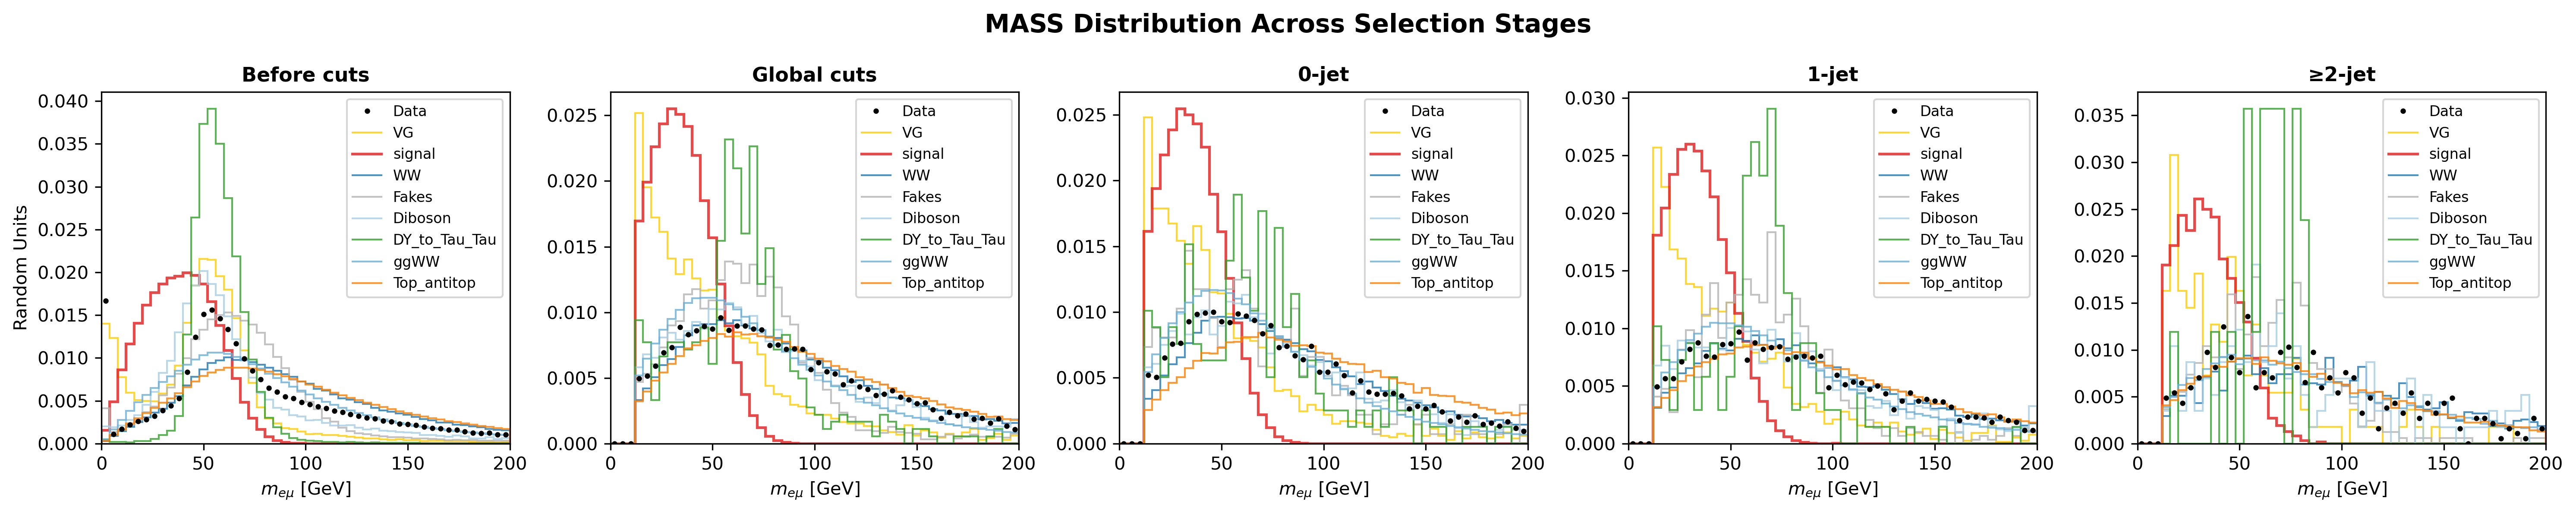


Plotting met...


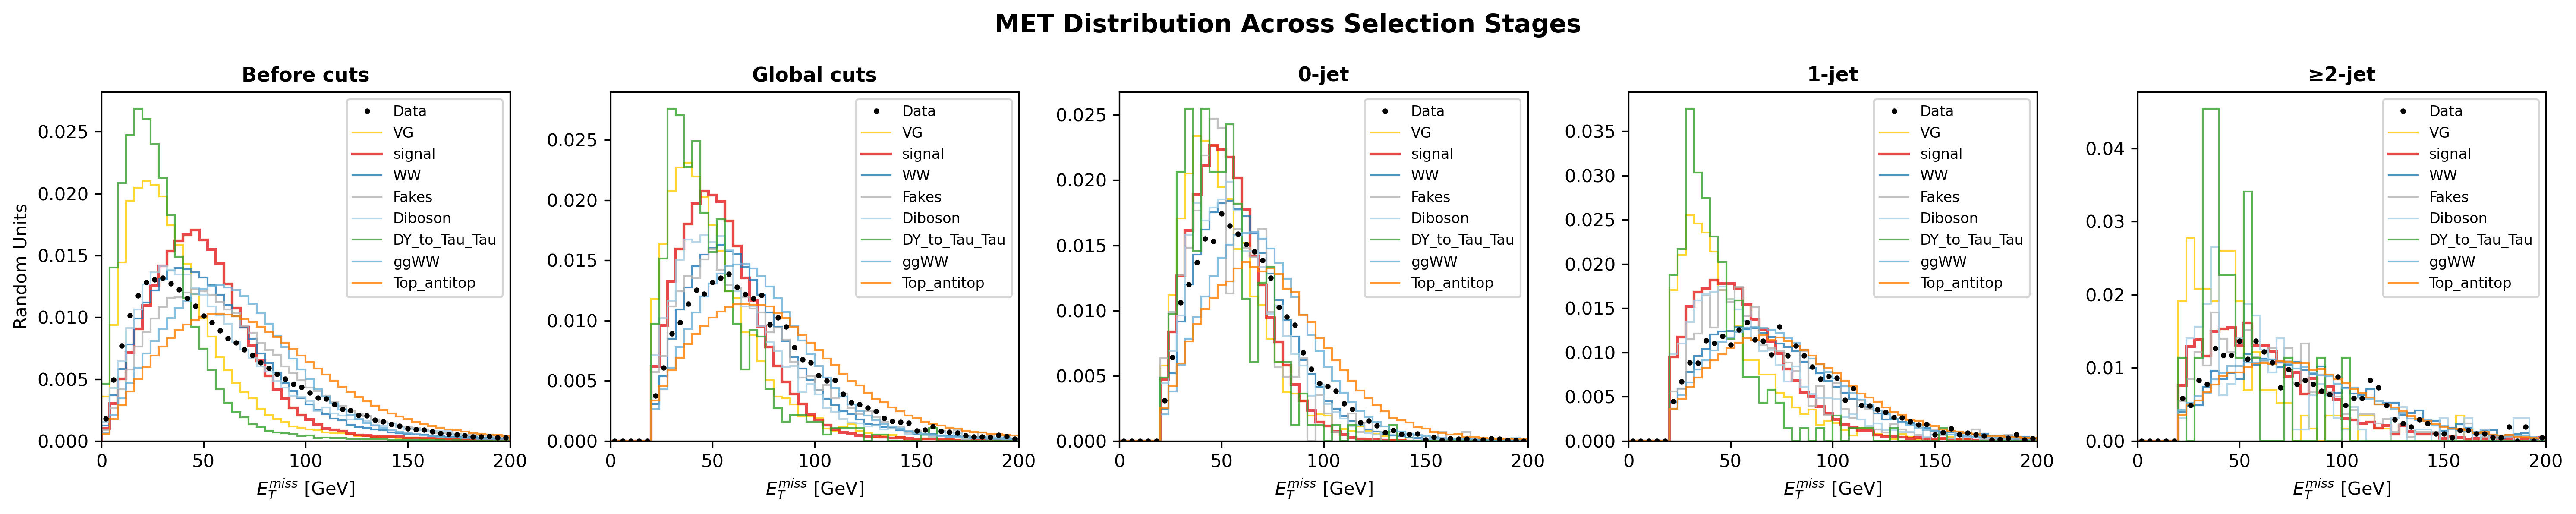


Plotting dphi...


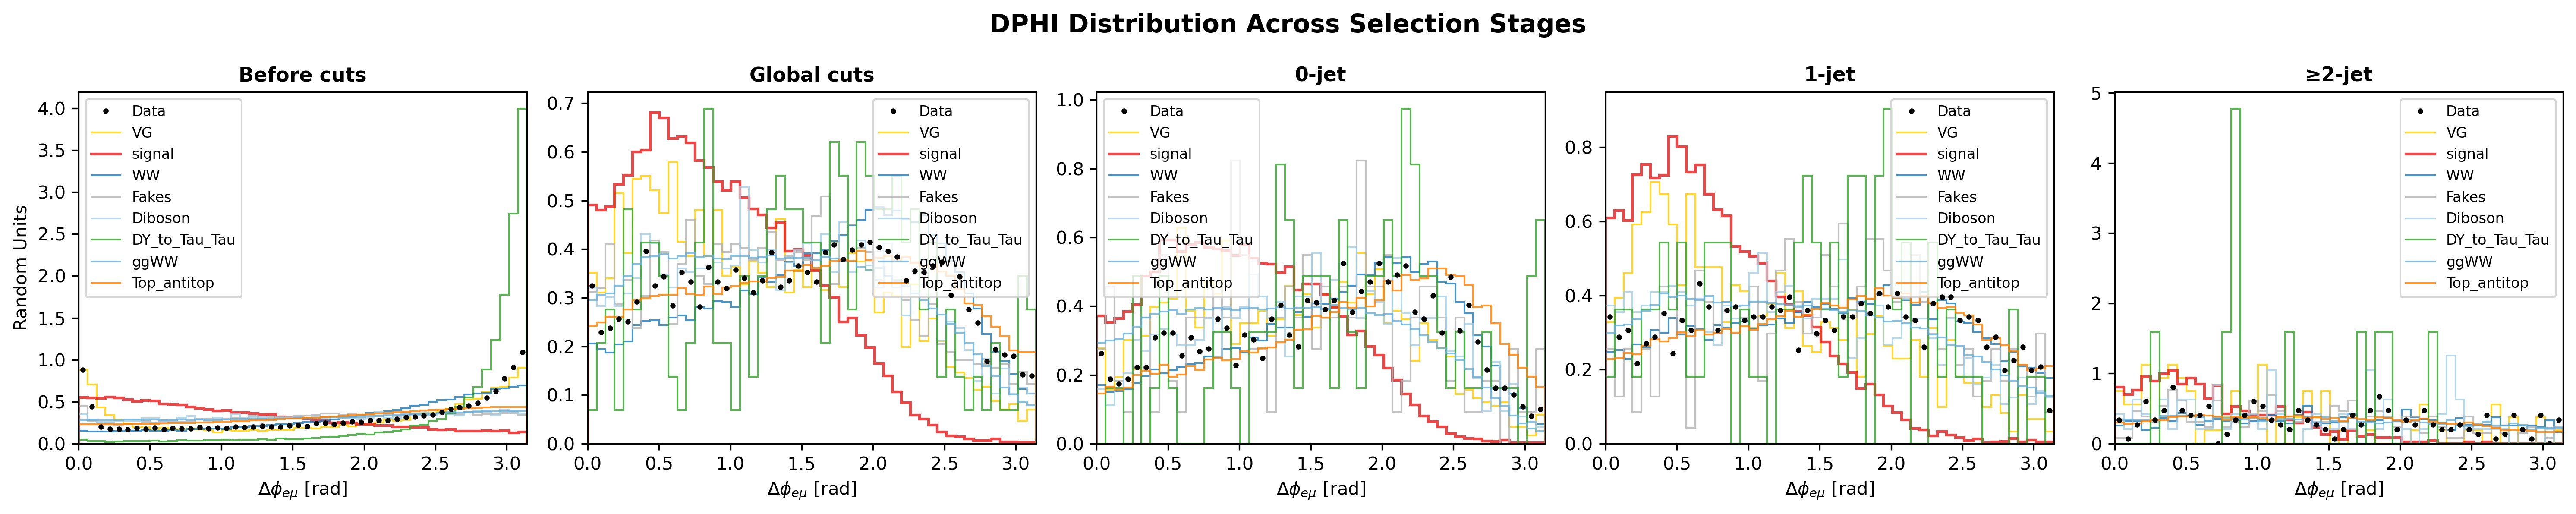


Plotting ptll...


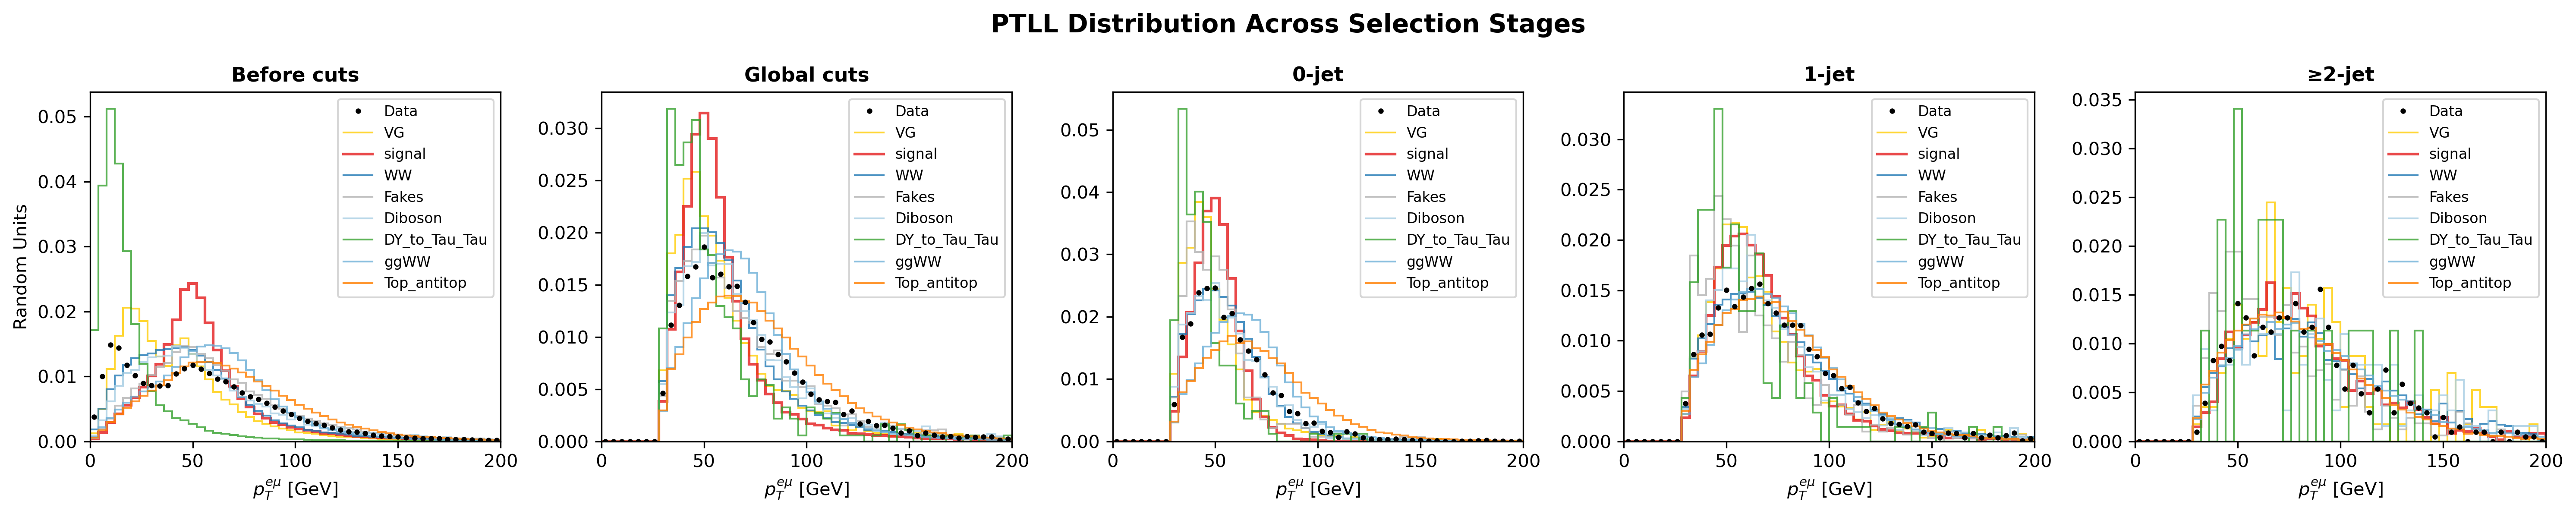


Plotting mt_higgs...


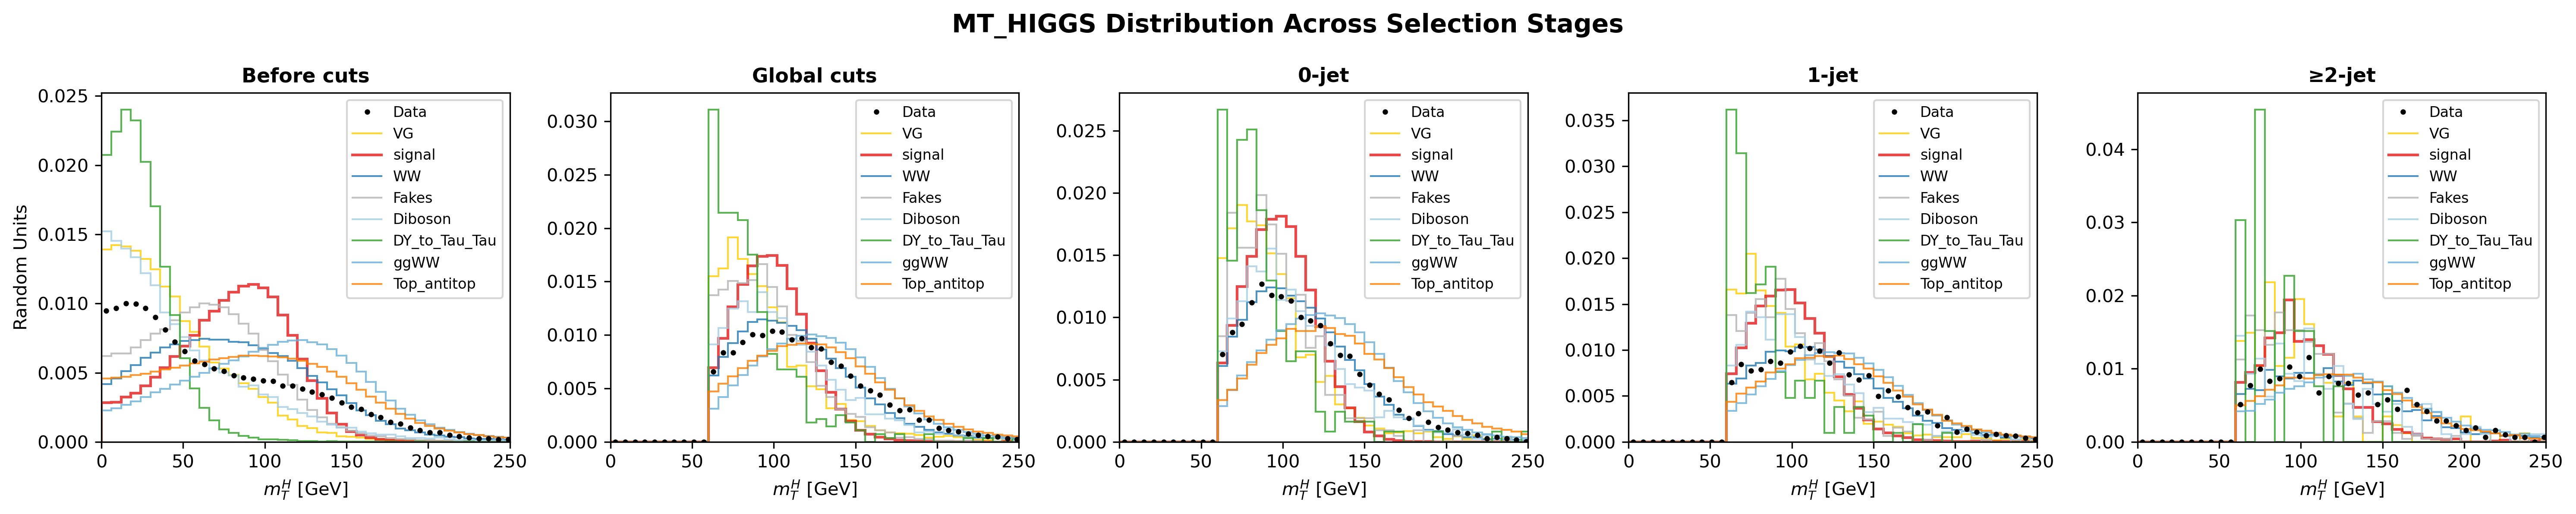


Plotting mt_l2_met...


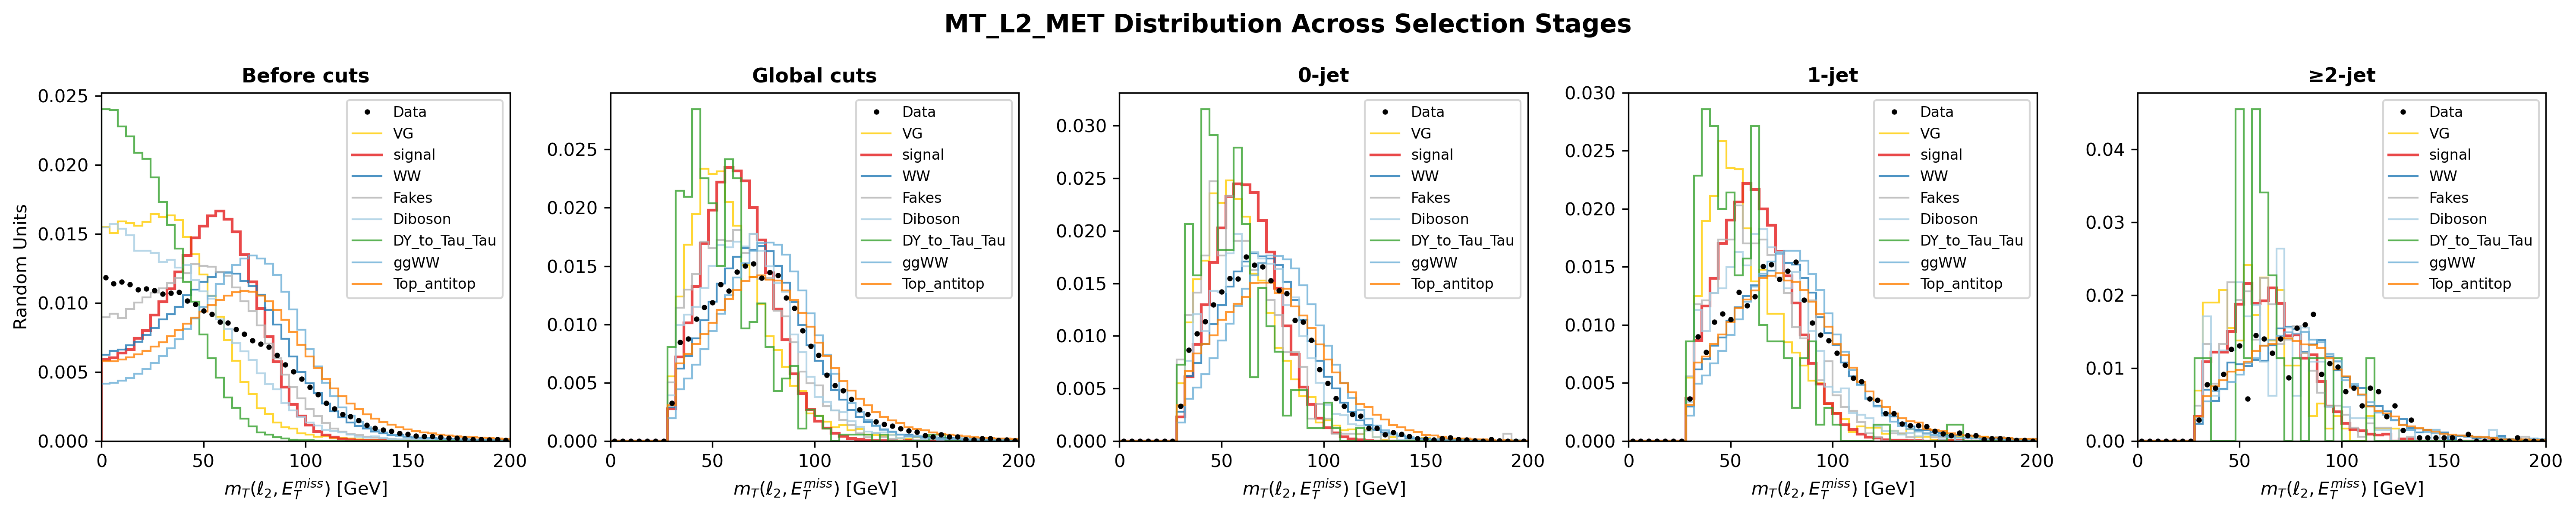


Plotting mjj...


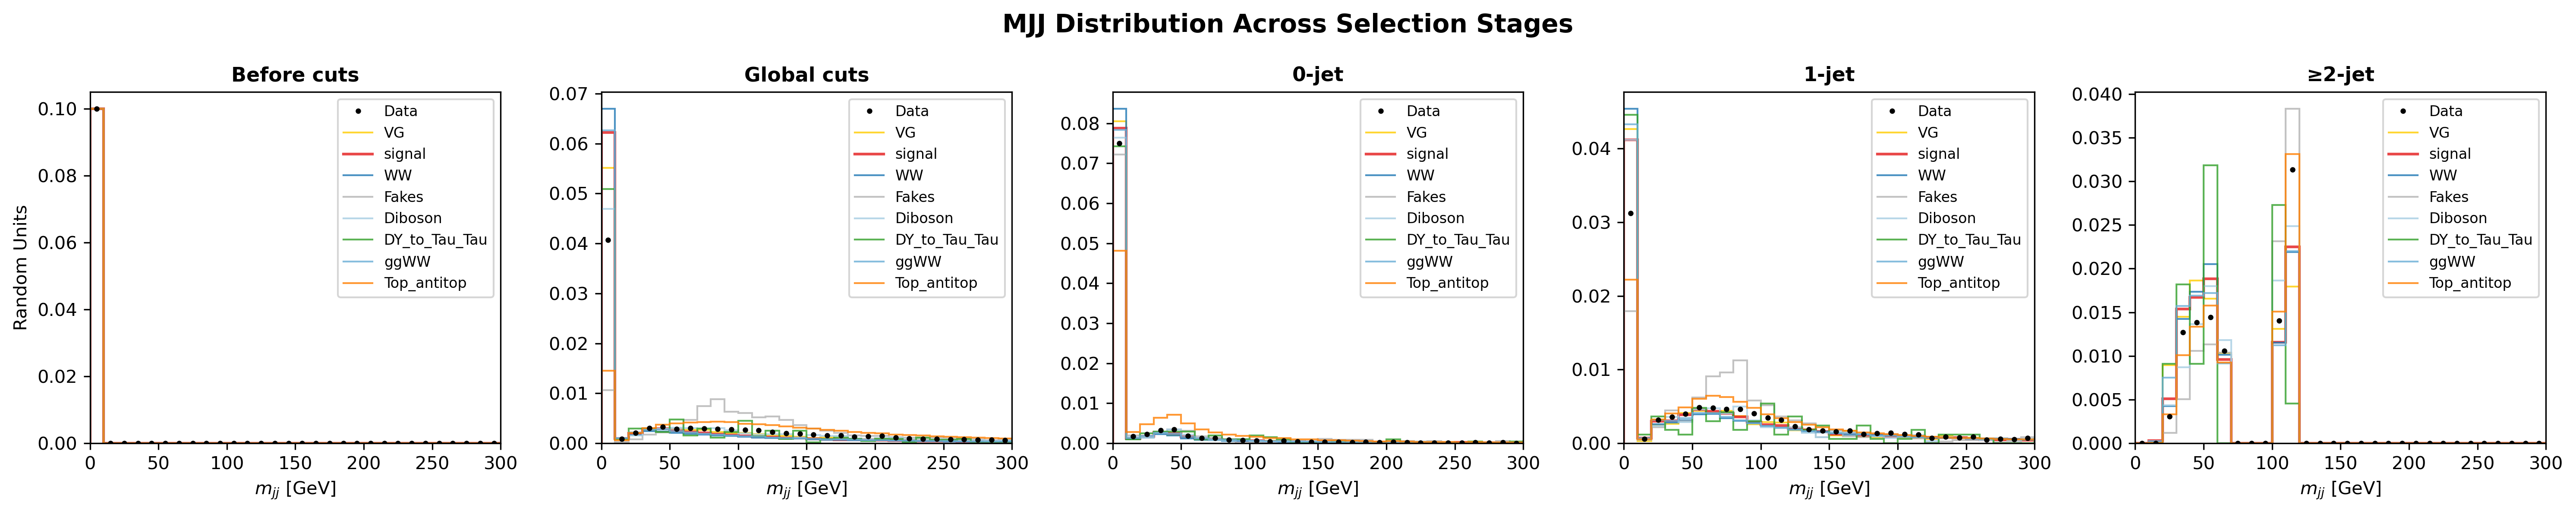

In [249]:
# Plot all variables
for var_name, var_props in variables_to_plot.items():
    print(f"\nPlotting {var_name}...")
    fig = plot_stage_comparison(var_name, var_props, hist_data_final)
    plt.show()

## Stacked plots

In [245]:
def plot_sr_cr_stacked(variable, var_props, hist_data_all):
    """Plot all SR and CR regions in 3x3 grid with CMS-style stacking"""

    regions = [
        ('SR_0jet', 'SR 0-jet'), ('SR_1jet', 'SR 1-jet'), ('SR_2jet', 'SR 2-jet'),
        ('CR_top_0jet', 'Top CR 0-jet'), ('CR_top_1jet', 'Top CR 1-jet'), 
        ('CR_top_2jet', 'Top CR 2-jet'), ('CR_tau_0jet', 'ττ CR 0-jet'),
        ('CR_tau_1jet', 'ττ CR 1-jet'), ('CR_tau_2jet', 'ττ CR 2-jet')
    ]

    fig, axes = plt.subplots(3, 3, figsize=(20, 16), dpi = 150)
    axes = axes.flatten()

    backgrounds, signal = get_backgrounds_and_signal()
    data_sample = get_data_sample()

    legend_handles = {}
    legend_created = False

    samples_to_cache = [s for s in backgrounds + [signal, data_sample] if s is not None]
    
    hist_cache = {}
    for sample in samples_to_cache:
        hist_cache[sample] = {}
        for stage, _ in regions:
            values, edges = get_histogram_data(hist_data_all, sample, stage, variable)
            if values is not None:
                hist_cache[sample][stage] = (values, edges)

    for idx, (stage, stage_label) in enumerate(regions):
        ax = axes[idx]

        edges = None
        for sample in hist_cache:
            if stage in hist_cache[sample]:
                _, edges = hist_cache[sample][stage]
                break

        if edges is None:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', 
                    transform=ax.transAxes, fontsize=12)
            ax.set_title(stage_label, fontsize=12, fontweight='bold')
            continue

        # Plot stacked backgrounds
        bg_values = []
        bg_colors = []
        bg_labels = []
        for sample in backgrounds:
            if sample in hist_cache and stage in hist_cache[sample]:
                values, _ = hist_cache[sample][stage]
                bg_values.append(values)
                bg_colors.append(SAMPLES[sample]["color"])
                bg_labels.append(sample)

        if bg_values:
            ax.hist(
                [edges[:-1] for _ in bg_values], 
                bins=edges, 
                weights=bg_values,
                stacked=True, 
                color=bg_colors,
                histtype='stepfilled', 
                alpha=1, 
                edgecolor='none', 
                linewidth=0.5
            )
            
            if not legend_created:
                for i, label in enumerate(bg_labels):
                    legend_handles[label] = mpatches.Rectangle(
                        (0, 0), 1, 1,
                        facecolor=bg_colors[i],
                        edgecolor='none',
                        linewidth=0.5,
                        alpha=1
                    )

        # Plot signal
        if signal and signal in hist_cache and stage in hist_cache[signal]:
            values, _ = hist_cache[signal][stage]
            
            ax.hist(
                edges[:-1], 
                bins=edges, 
                weights=values, 
                histtype='step',
                color=SAMPLES[signal]["color"], 
                linewidth=2
            )
            
            if not legend_created:
                legend_handles[signal] = plt.Line2D(
                    [0], [0], 
                    color=SAMPLES[signal]["color"], 
                    linewidth=2
                )

        # Plot data 
        if data_sample and data_sample in hist_cache and stage in hist_cache[data_sample]:
            values, _ = hist_cache[data_sample][stage]
            centers = 0.5 * (edges[:-1] + edges[1:])
            ax.plot(centers, values, 'o', color='black', markersize=4, linestyle='none', zorder=10)
            
            if not legend_created:
                legend_handles[data_sample] = plt.Line2D(
                    [0], [0], 
                    marker='o', 
                    color='black', 
                    markersize=4,
                    linestyle='none'
                )

        if not legend_created and legend_handles:
            legend_created = True

    
        # AUTO-ADJUST X-AXIS LIMITS
        # Find data range
        all_values = np.concatenate([v for v in bg_values]) if bg_values else np.array([])
        
        if signal and signal in hist_cache and stage in hist_cache[signal]:
            sig_values, _ = hist_cache[signal][stage]
            all_values = np.concatenate([all_values, sig_values])
        
        if data_sample and data_sample in hist_cache and stage in hist_cache[data_sample]:
            data_values, _ = hist_cache[data_sample][stage]
            all_values = np.concatenate([all_values, data_values])
        
        # Find non-zero range
        non_zero_bins = np.where(all_values > 0)[0]
        if len(non_zero_bins) > 0:
            xmin = edges[non_zero_bins[0]]
            xmax = edges[min(non_zero_bins[-1] + 2, len(edges) - 1)] 
            ax.set_xlim(xmin, xmax)
        else:
            ax.set_xlim(var_props['xlim'])

        # Axis settings
        ax.set_xlabel(var_props['xlabel'], fontsize=11)
        ax.set_ylabel('Events', fontsize=11)
        ax.set_yscale('log')
        ax.set_ylim(bottom=1)
        ax.set_title(stage_label, fontsize=12, fontweight='bold')

    #  legend
    ordered_handles = []
    ordered_labels = []

    if data_sample and data_sample in legend_handles:
        ordered_labels.append(data_sample)
        ordered_handles.append(legend_handles[data_sample])

    if signal and signal in legend_handles:
        ordered_labels.append(signal)
        ordered_handles.append(legend_handles[signal])

    for sample in reversed(backgrounds):
        if sample in legend_handles:
            ordered_labels.append(sample)
            ordered_handles.append(legend_handles[sample])

    if ordered_handles:
        fig.legend(
            ordered_handles, 
            ordered_labels,
            loc='center right', 
            bbox_to_anchor=(0.98, 0.5),
            fontsize=11, 
            frameon=True, 
            title='Samples', 
            title_fontsize=12
        )

    plt.suptitle(f'{variable.upper()} - Signal & Control Regions', 
                fontsize=17, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 0.87, 0.96])

    return fig


Creating stacked histogram plots...
Plotting mass...


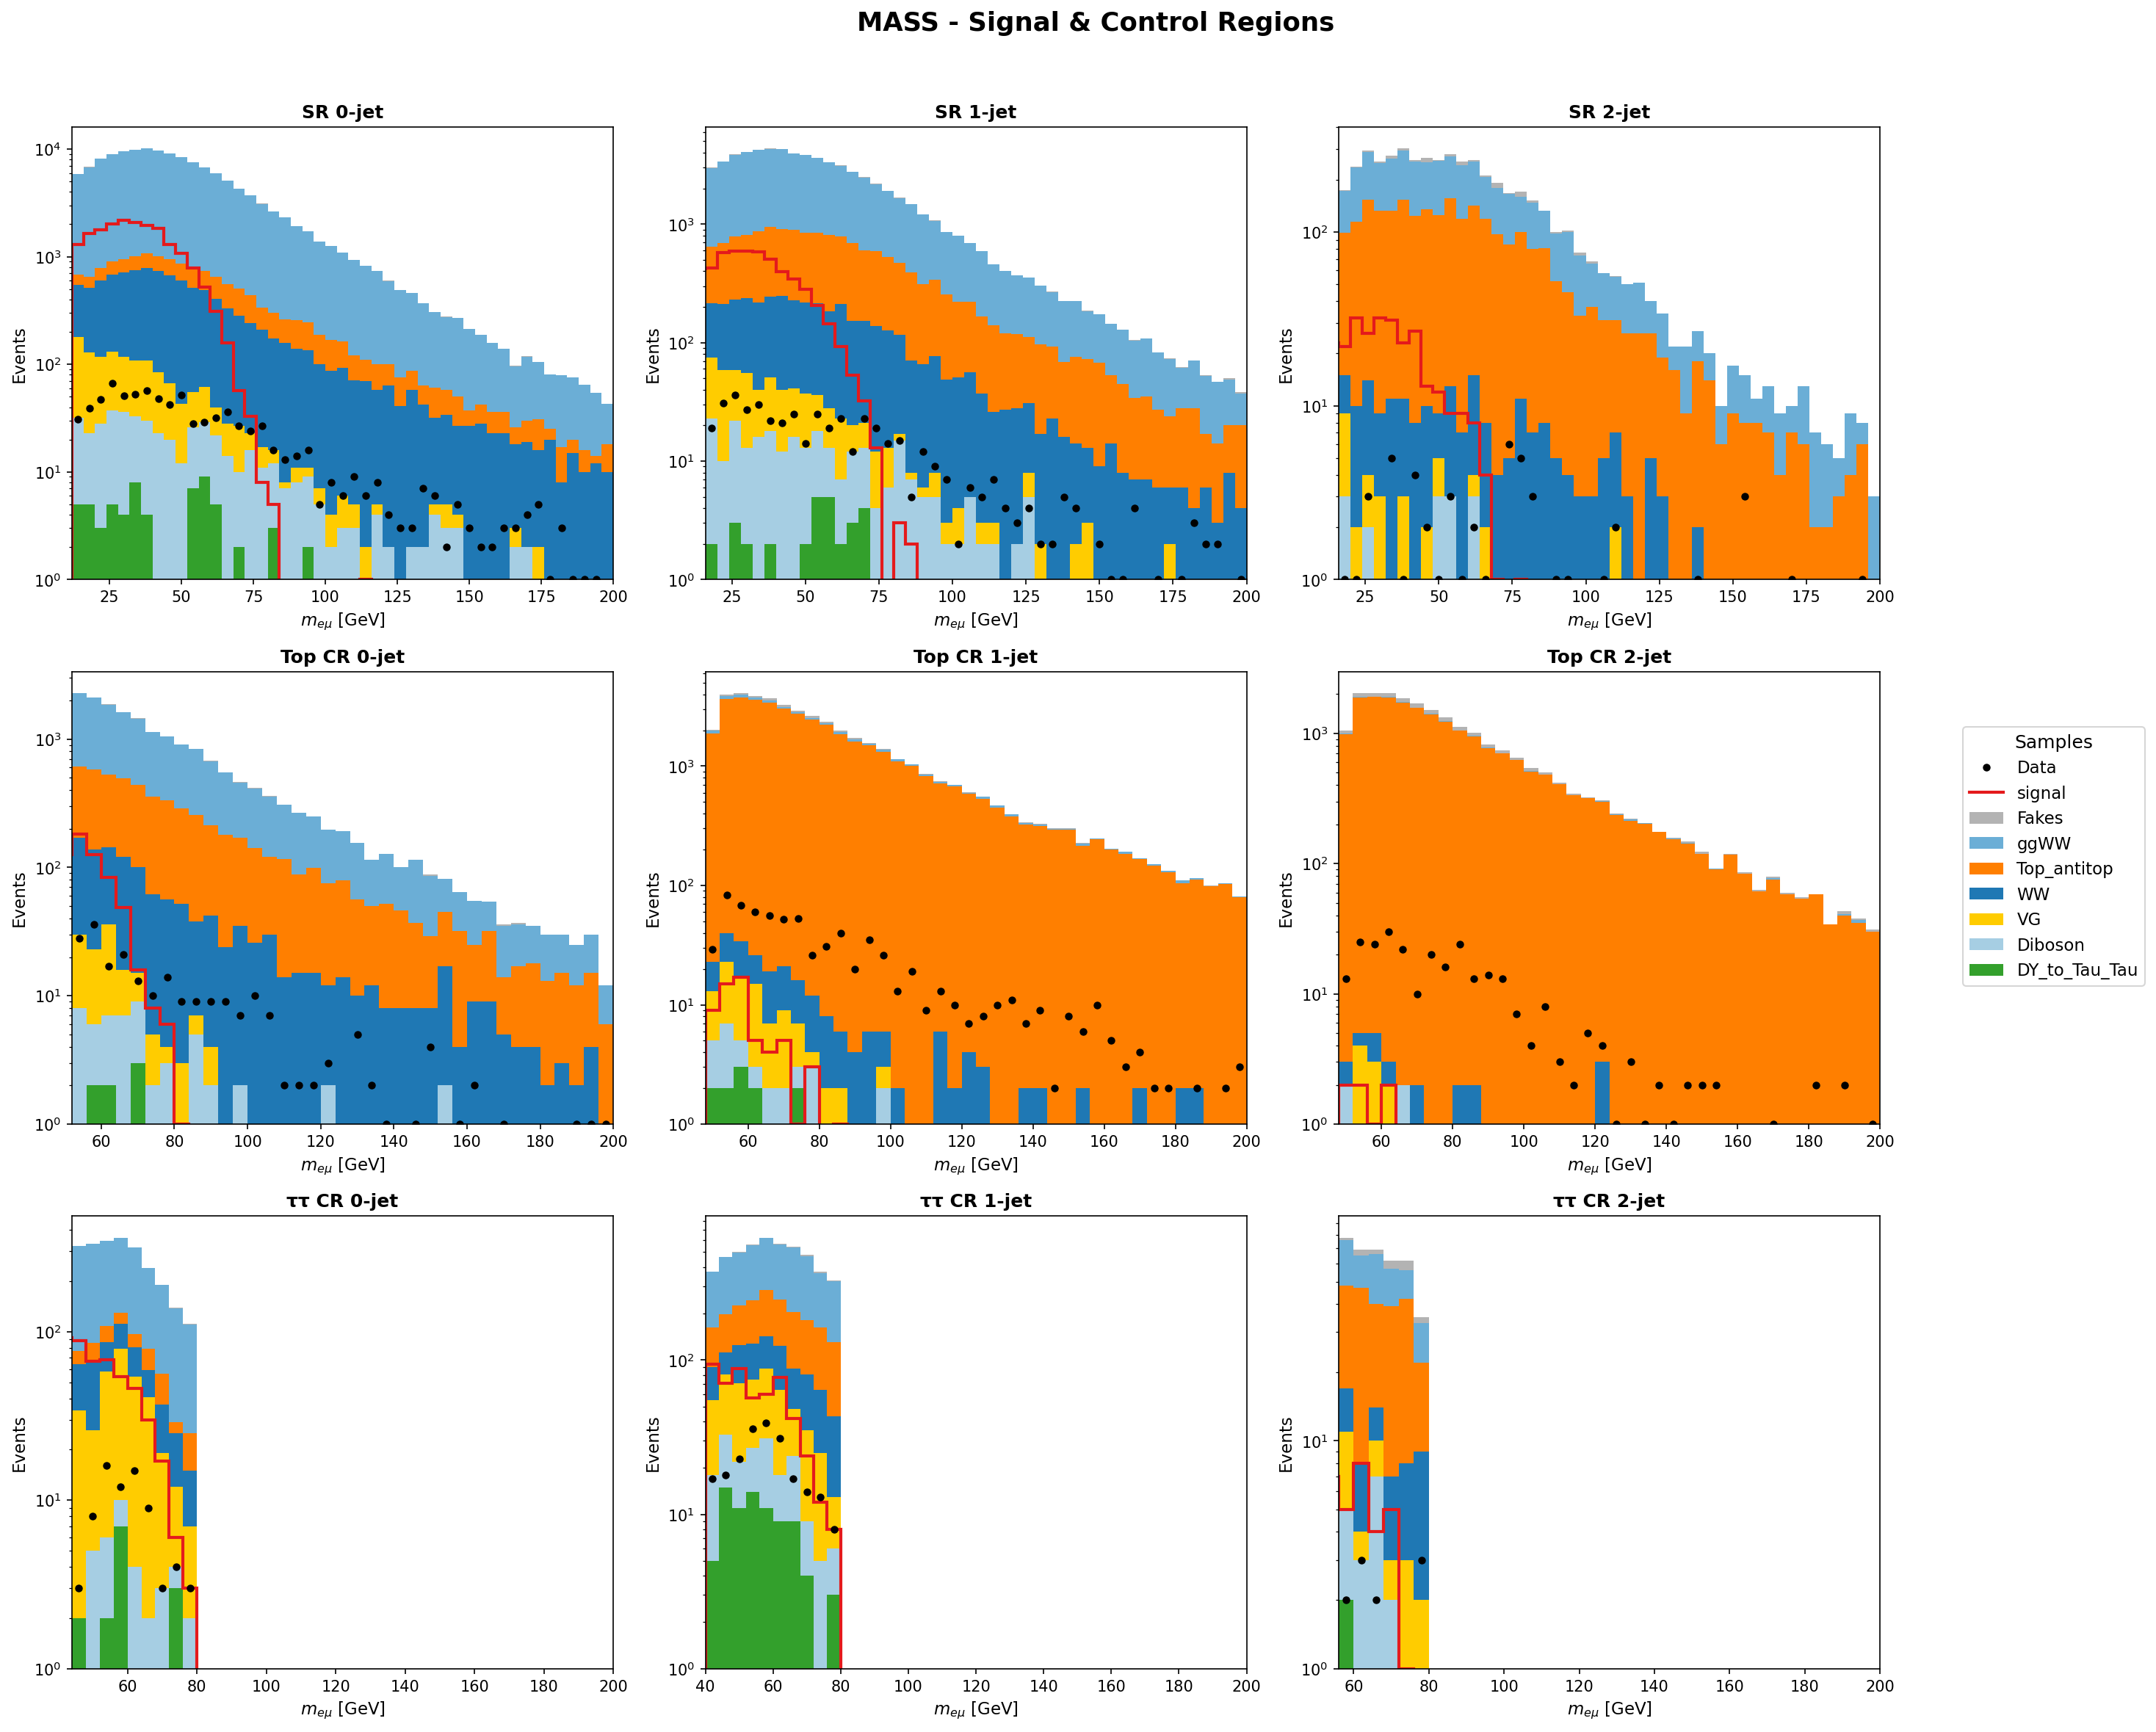

Plotting met...


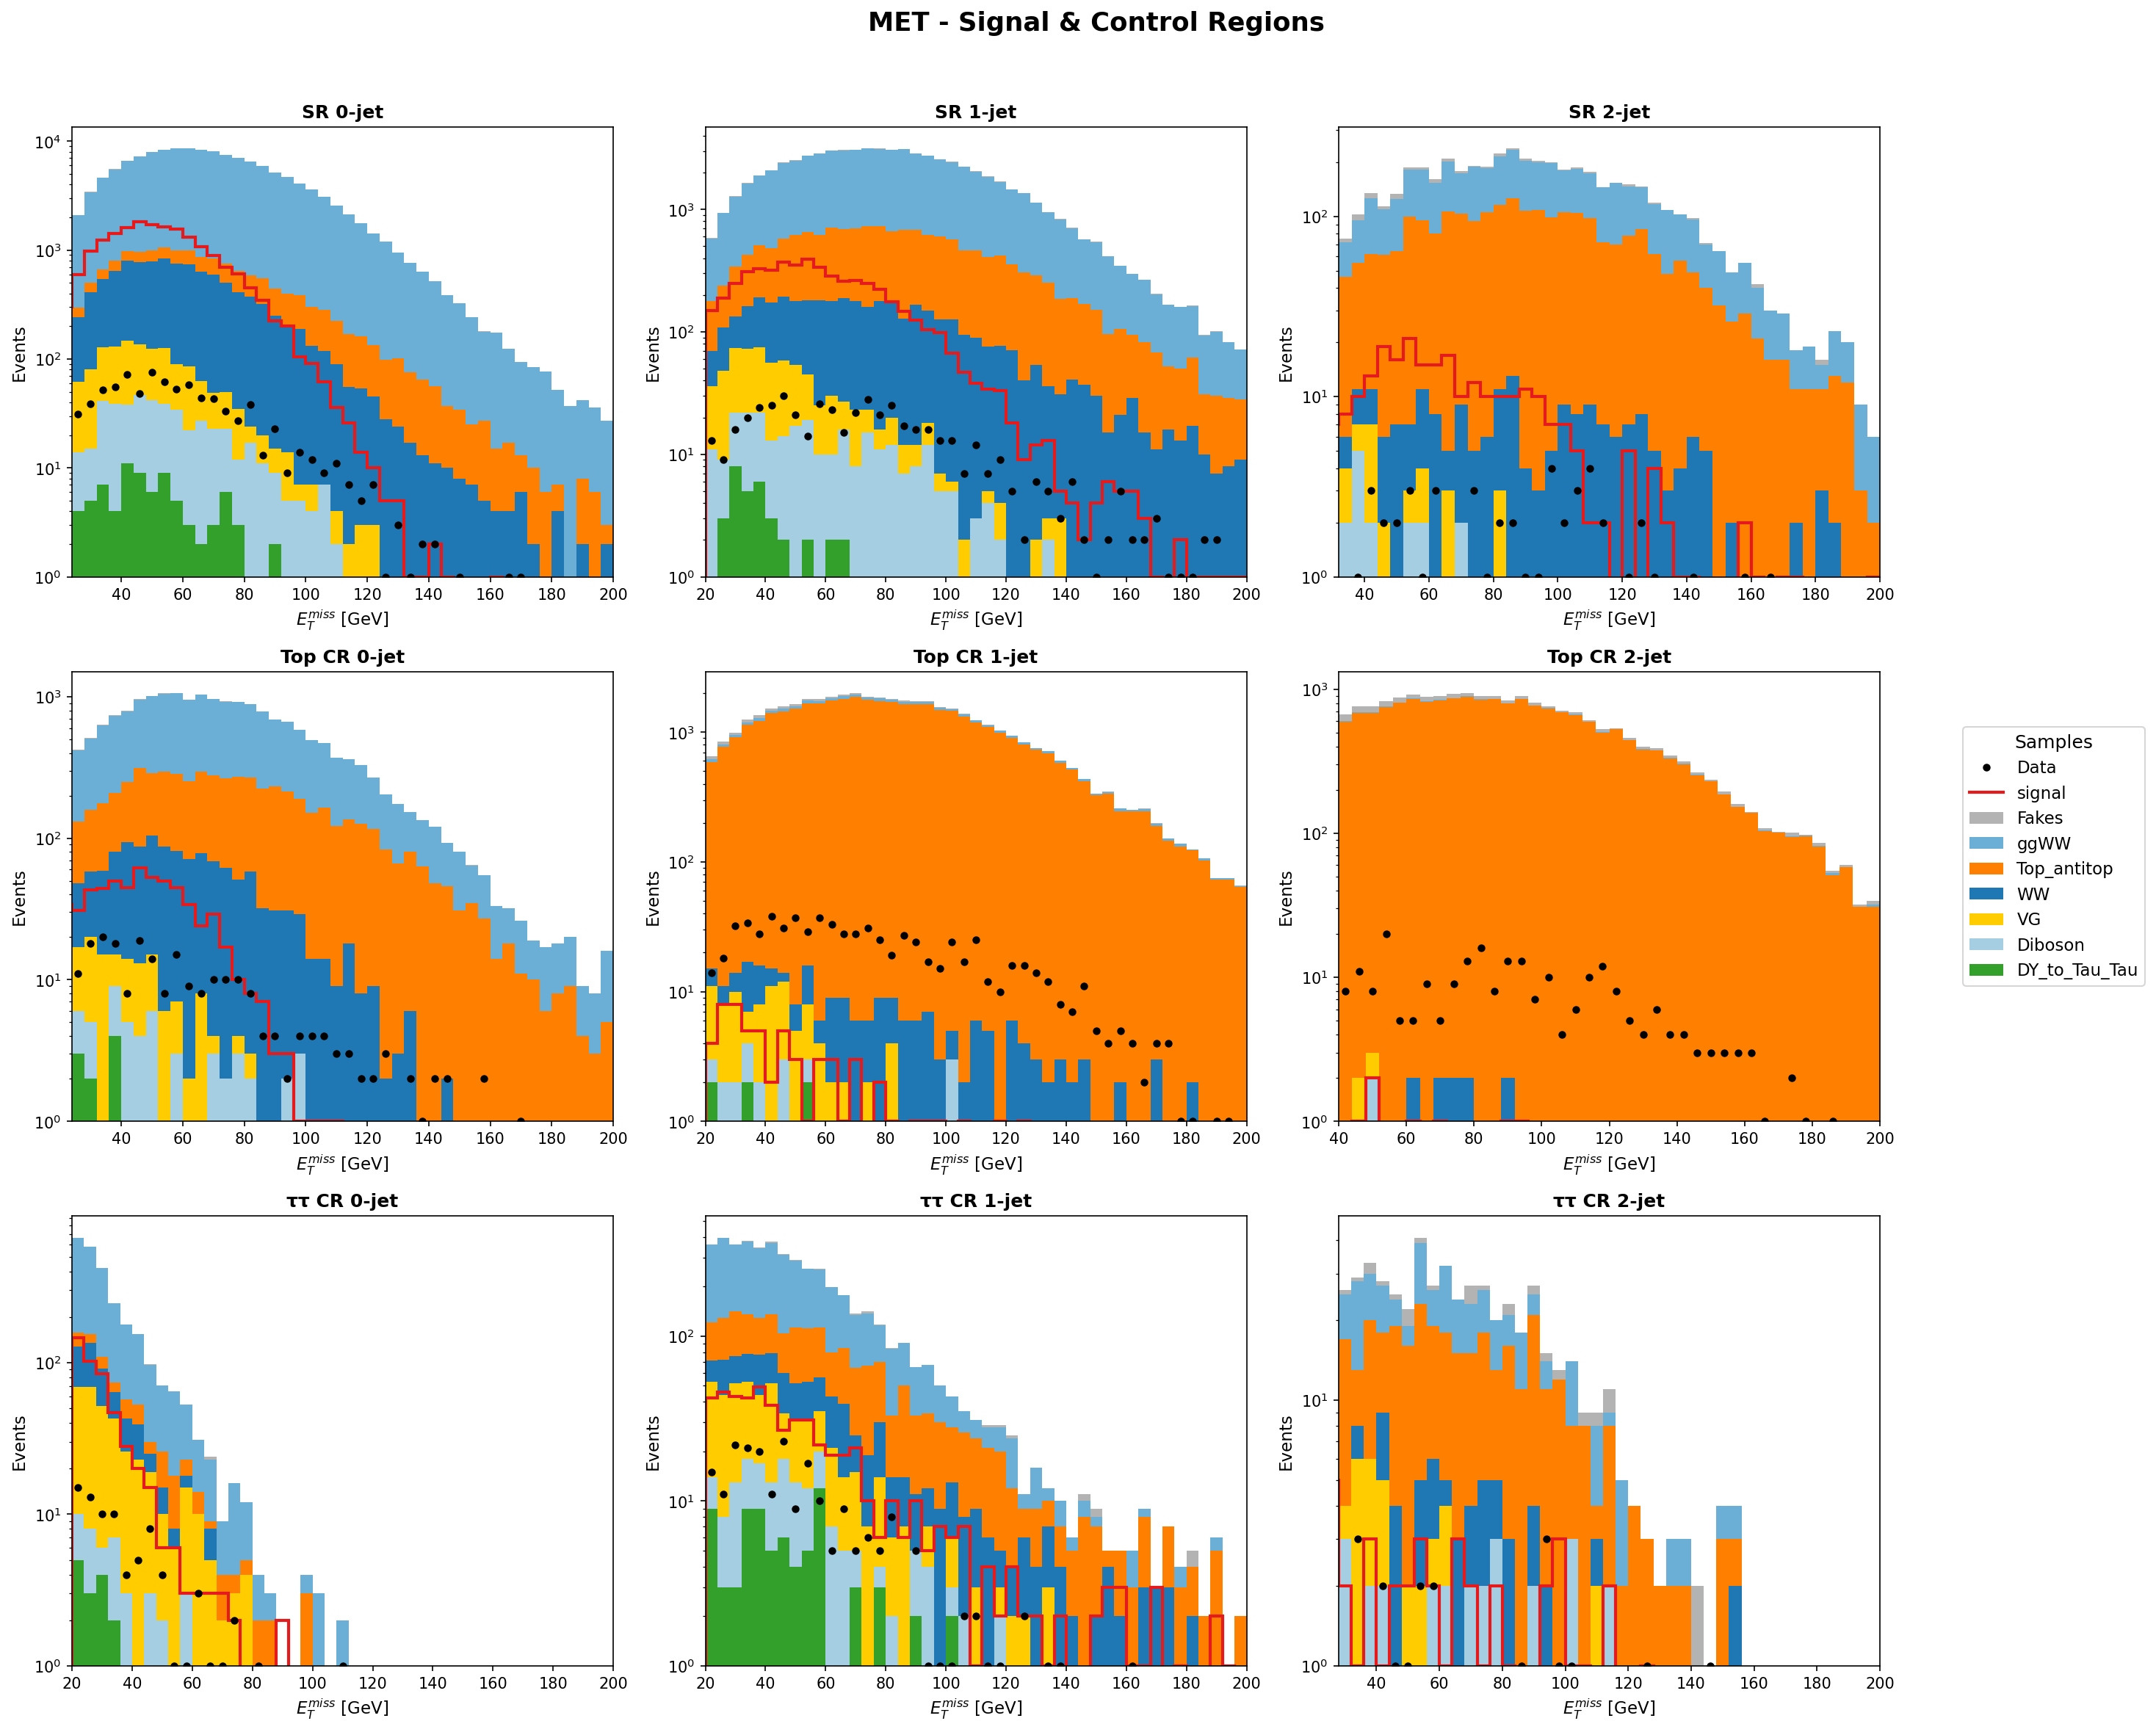

Plotting dphi...


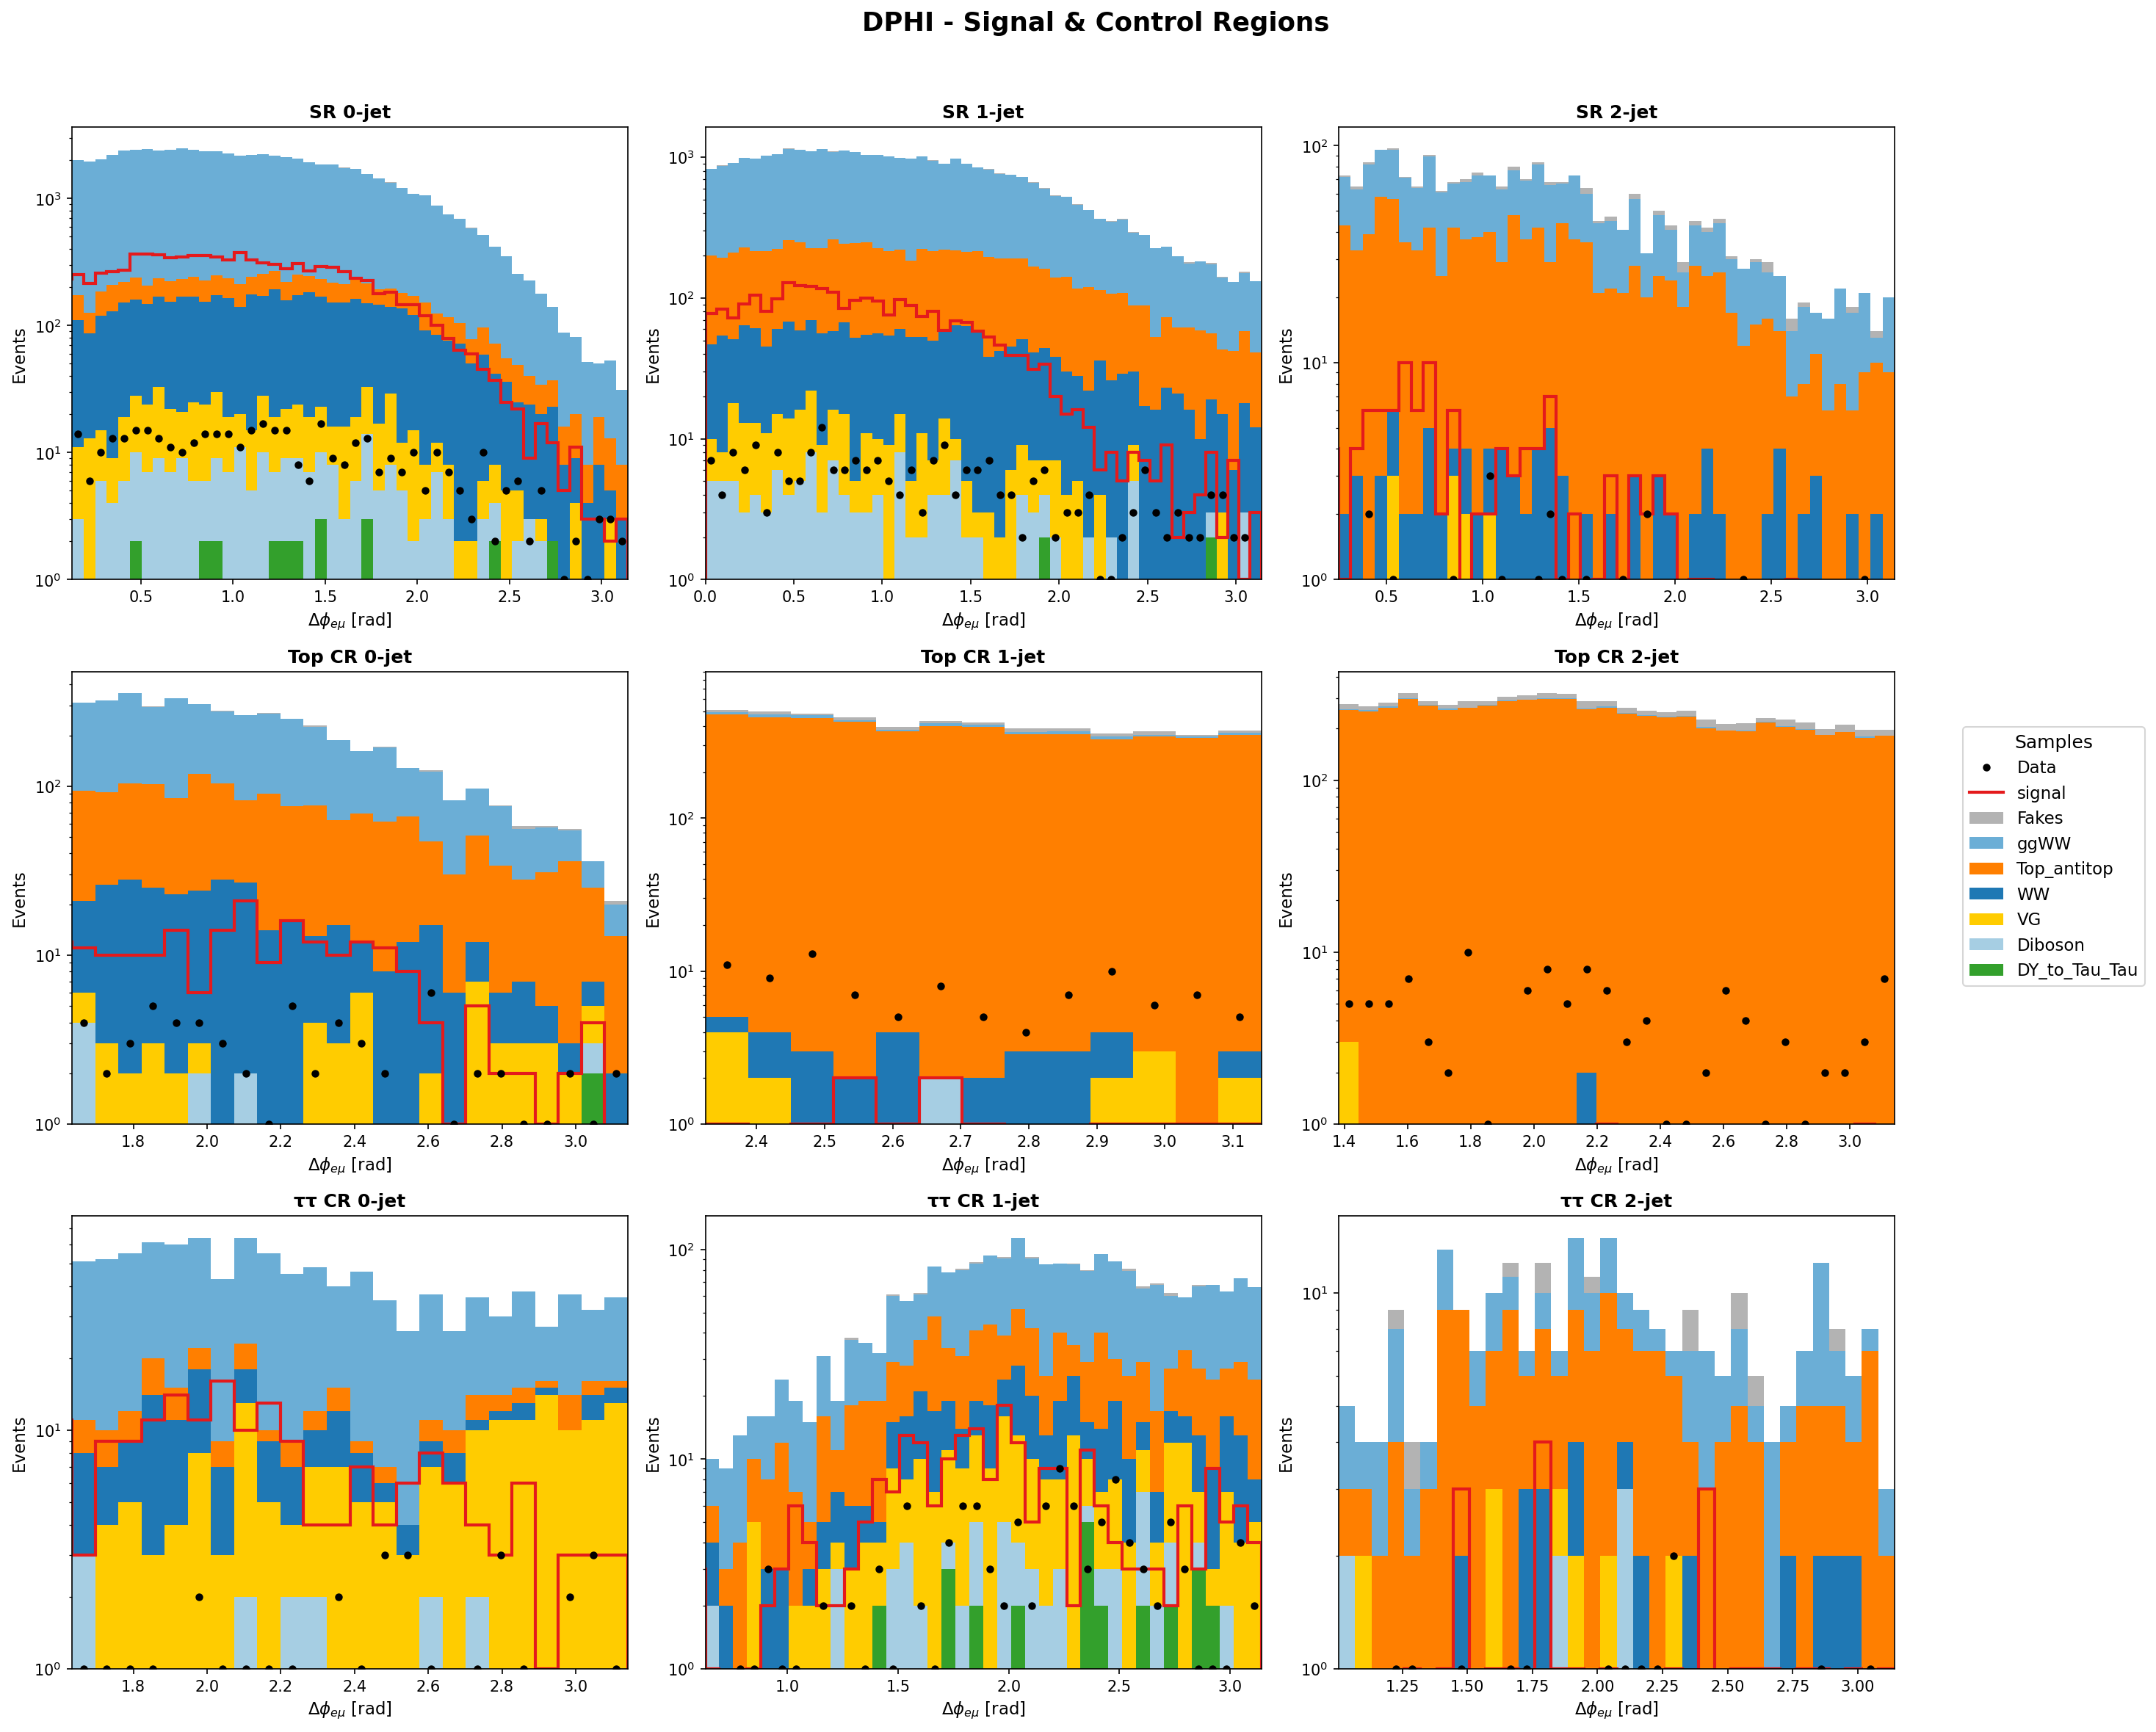

Plotting ptll...


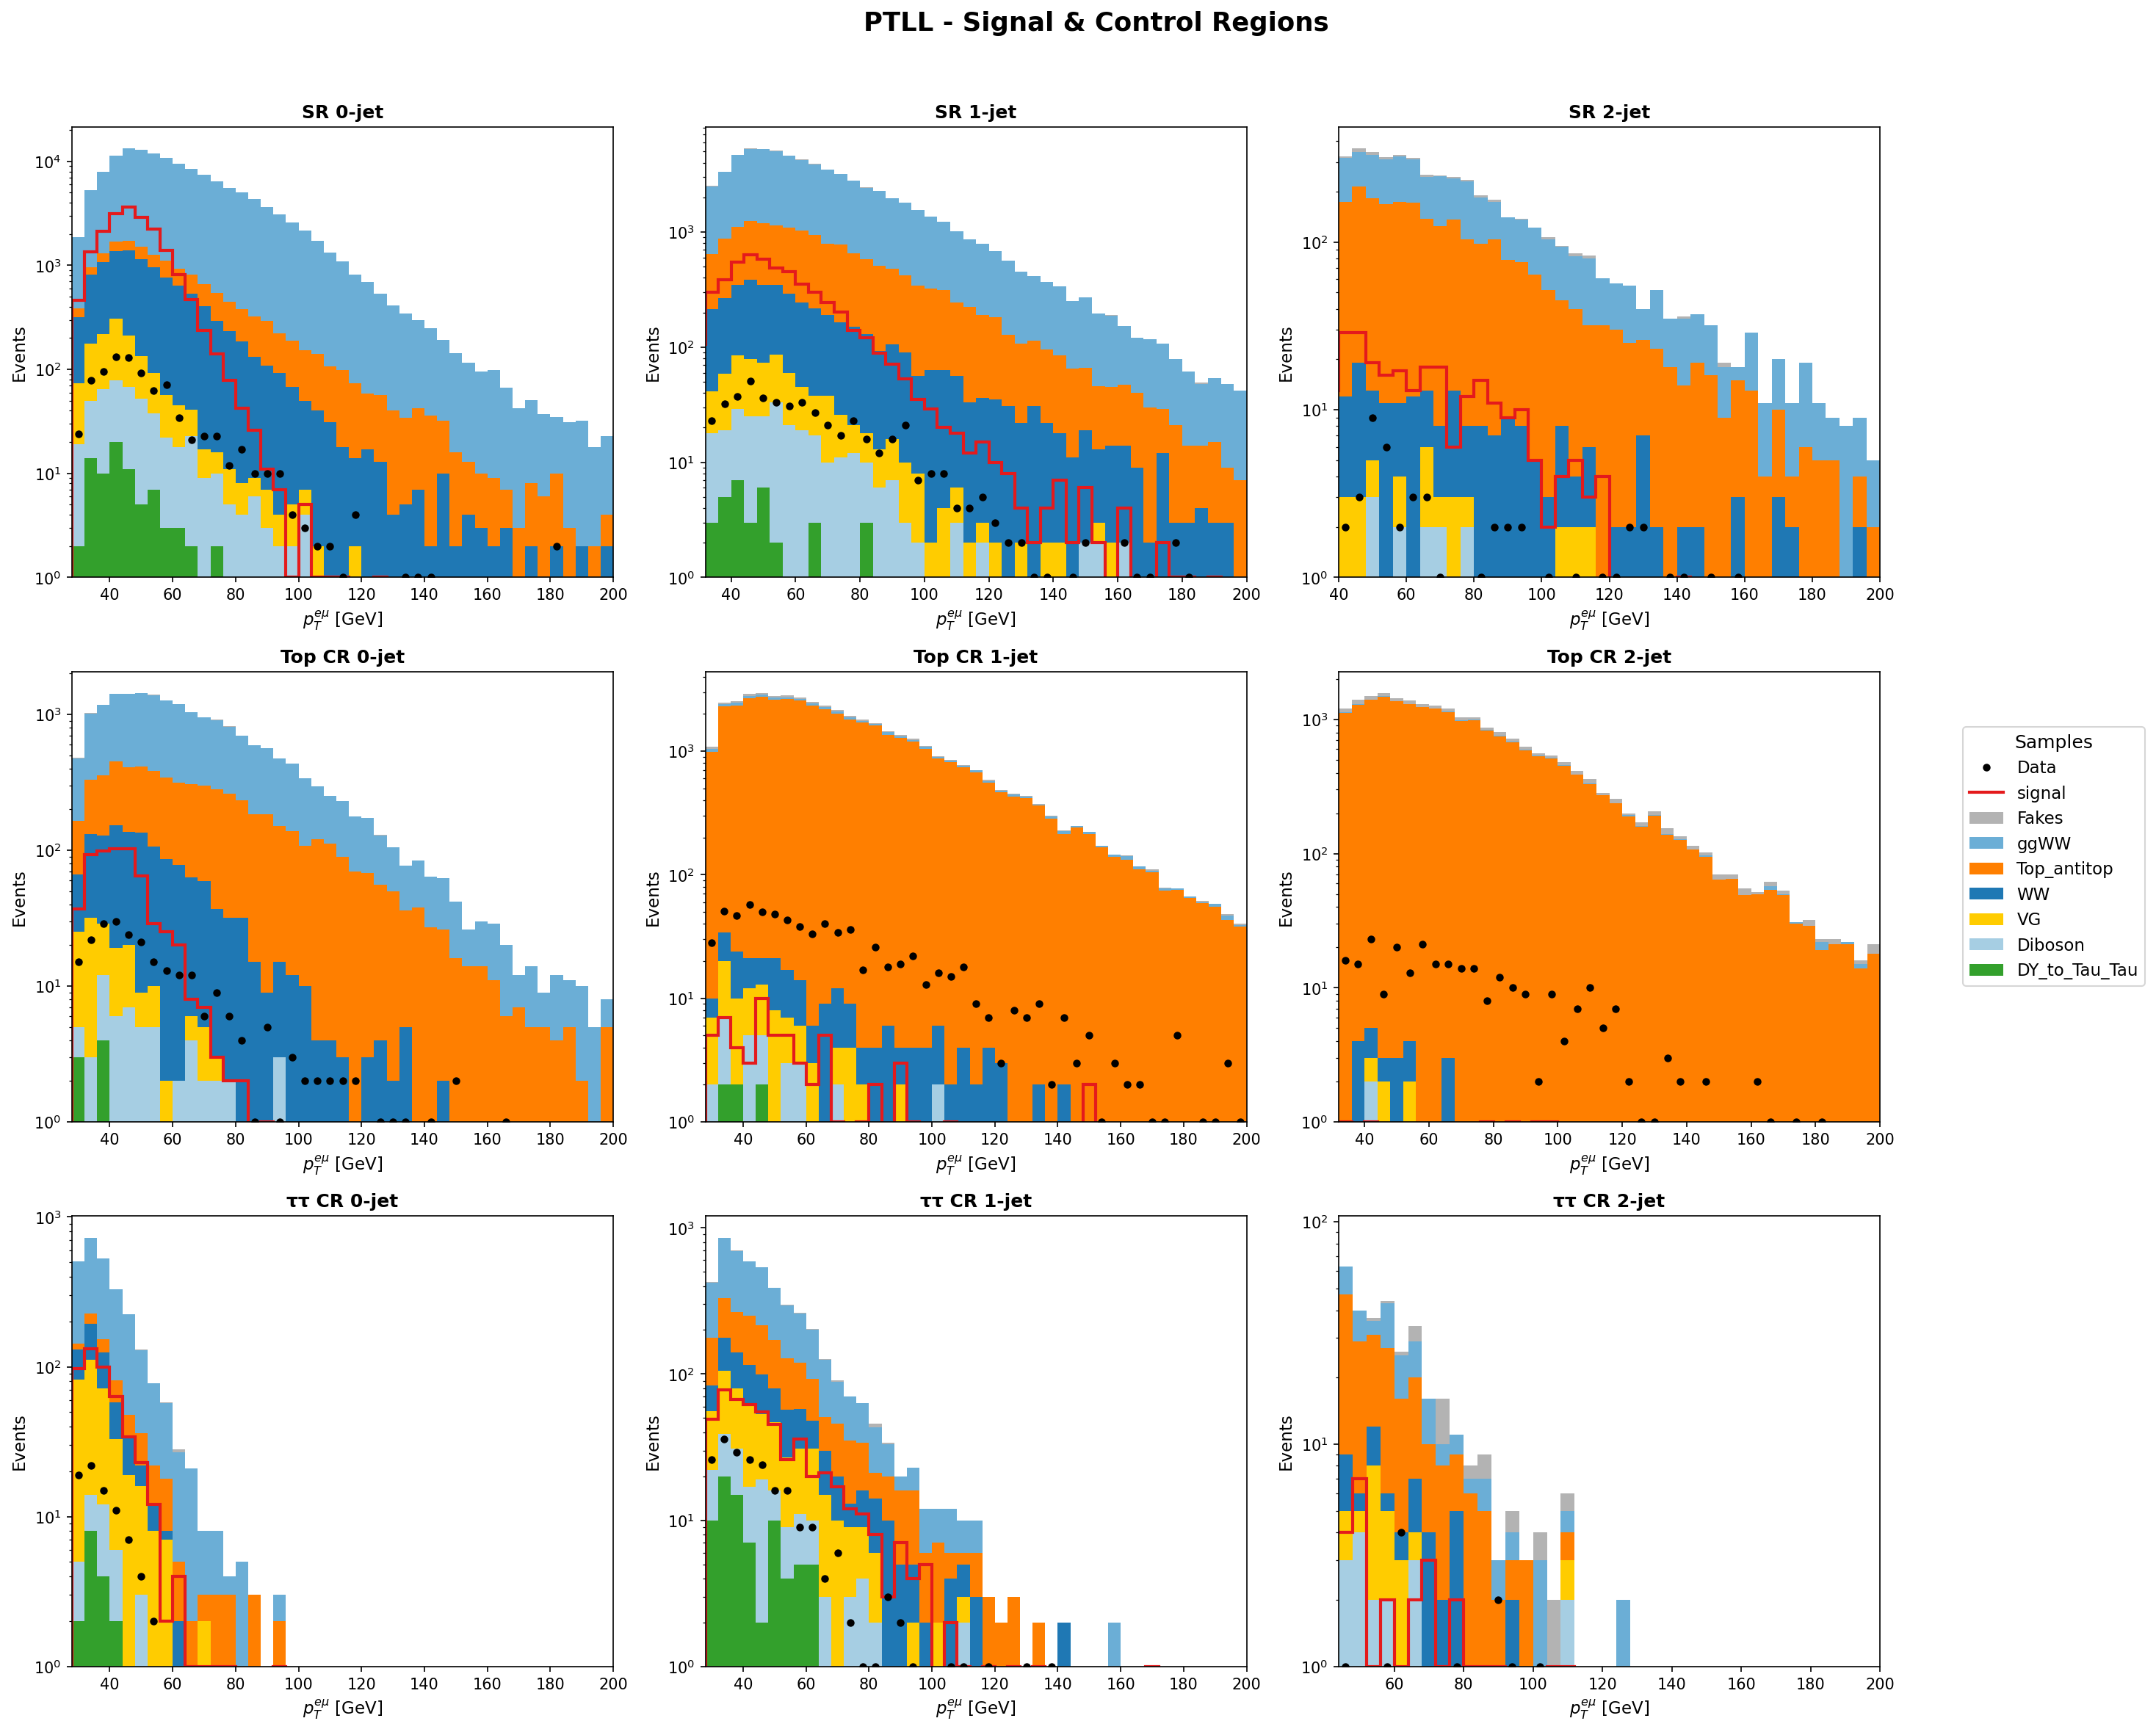

Plotting mt_higgs...


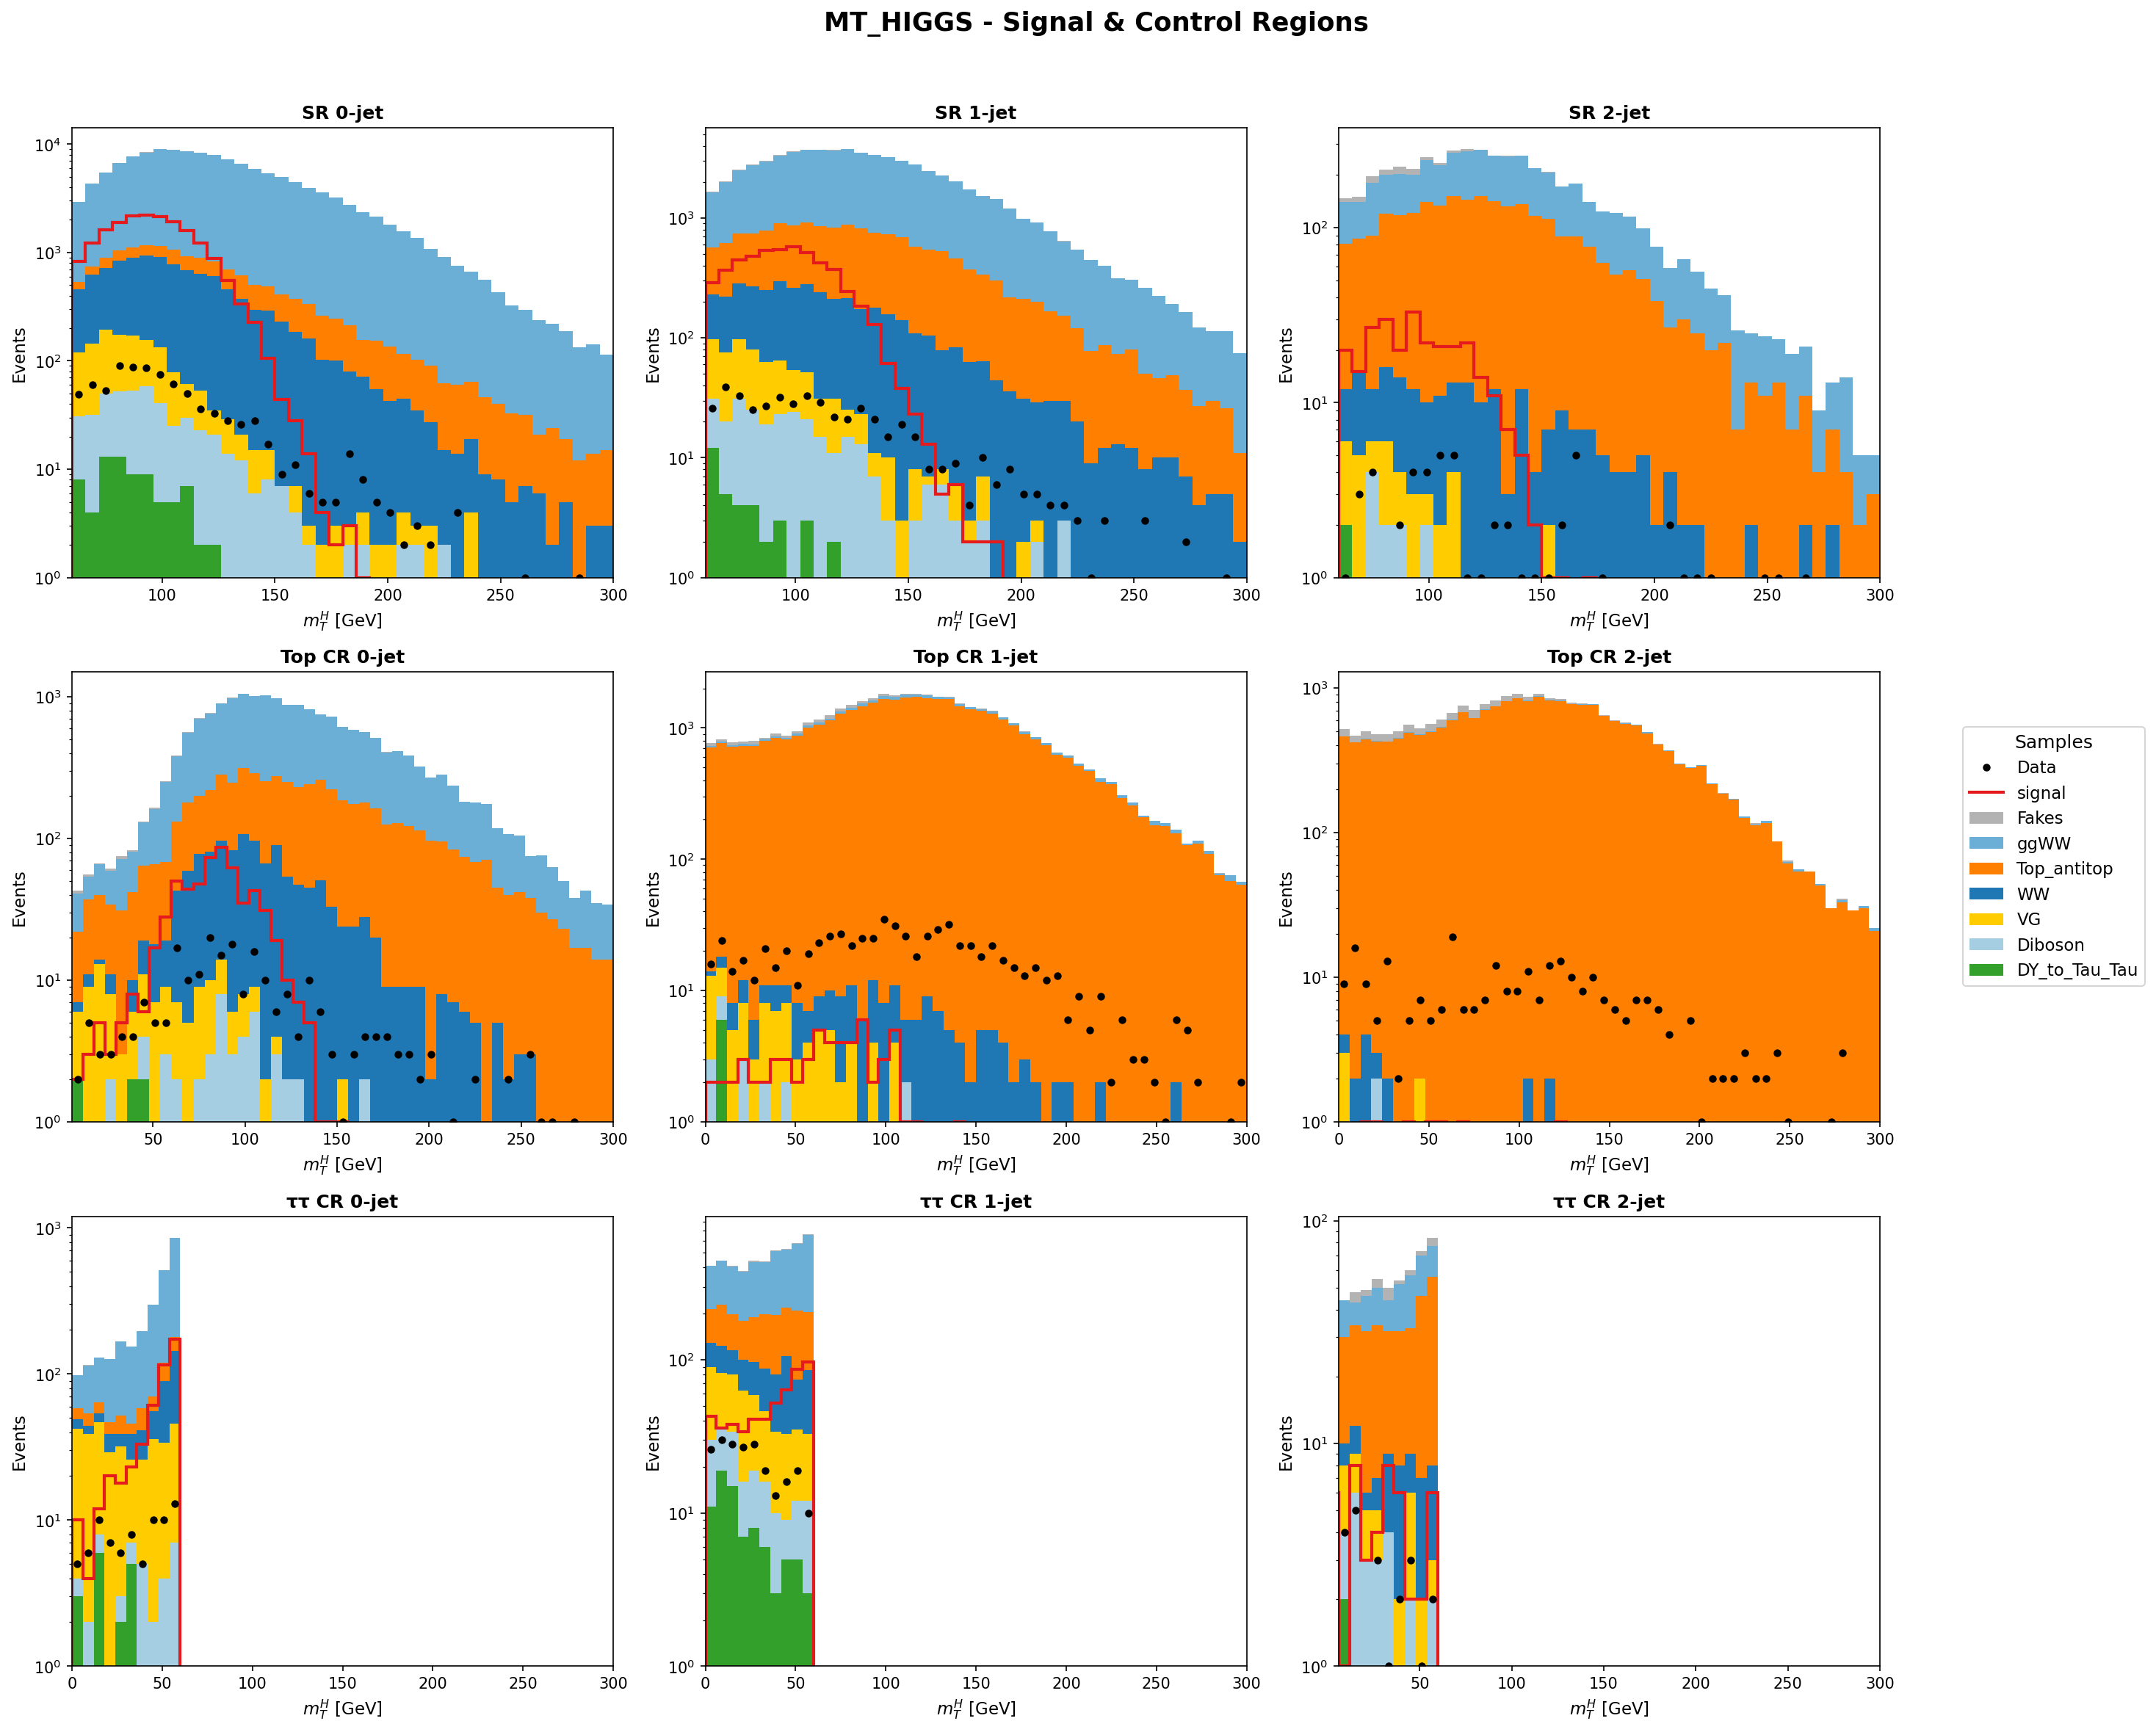

Plotting mt_l2_met...


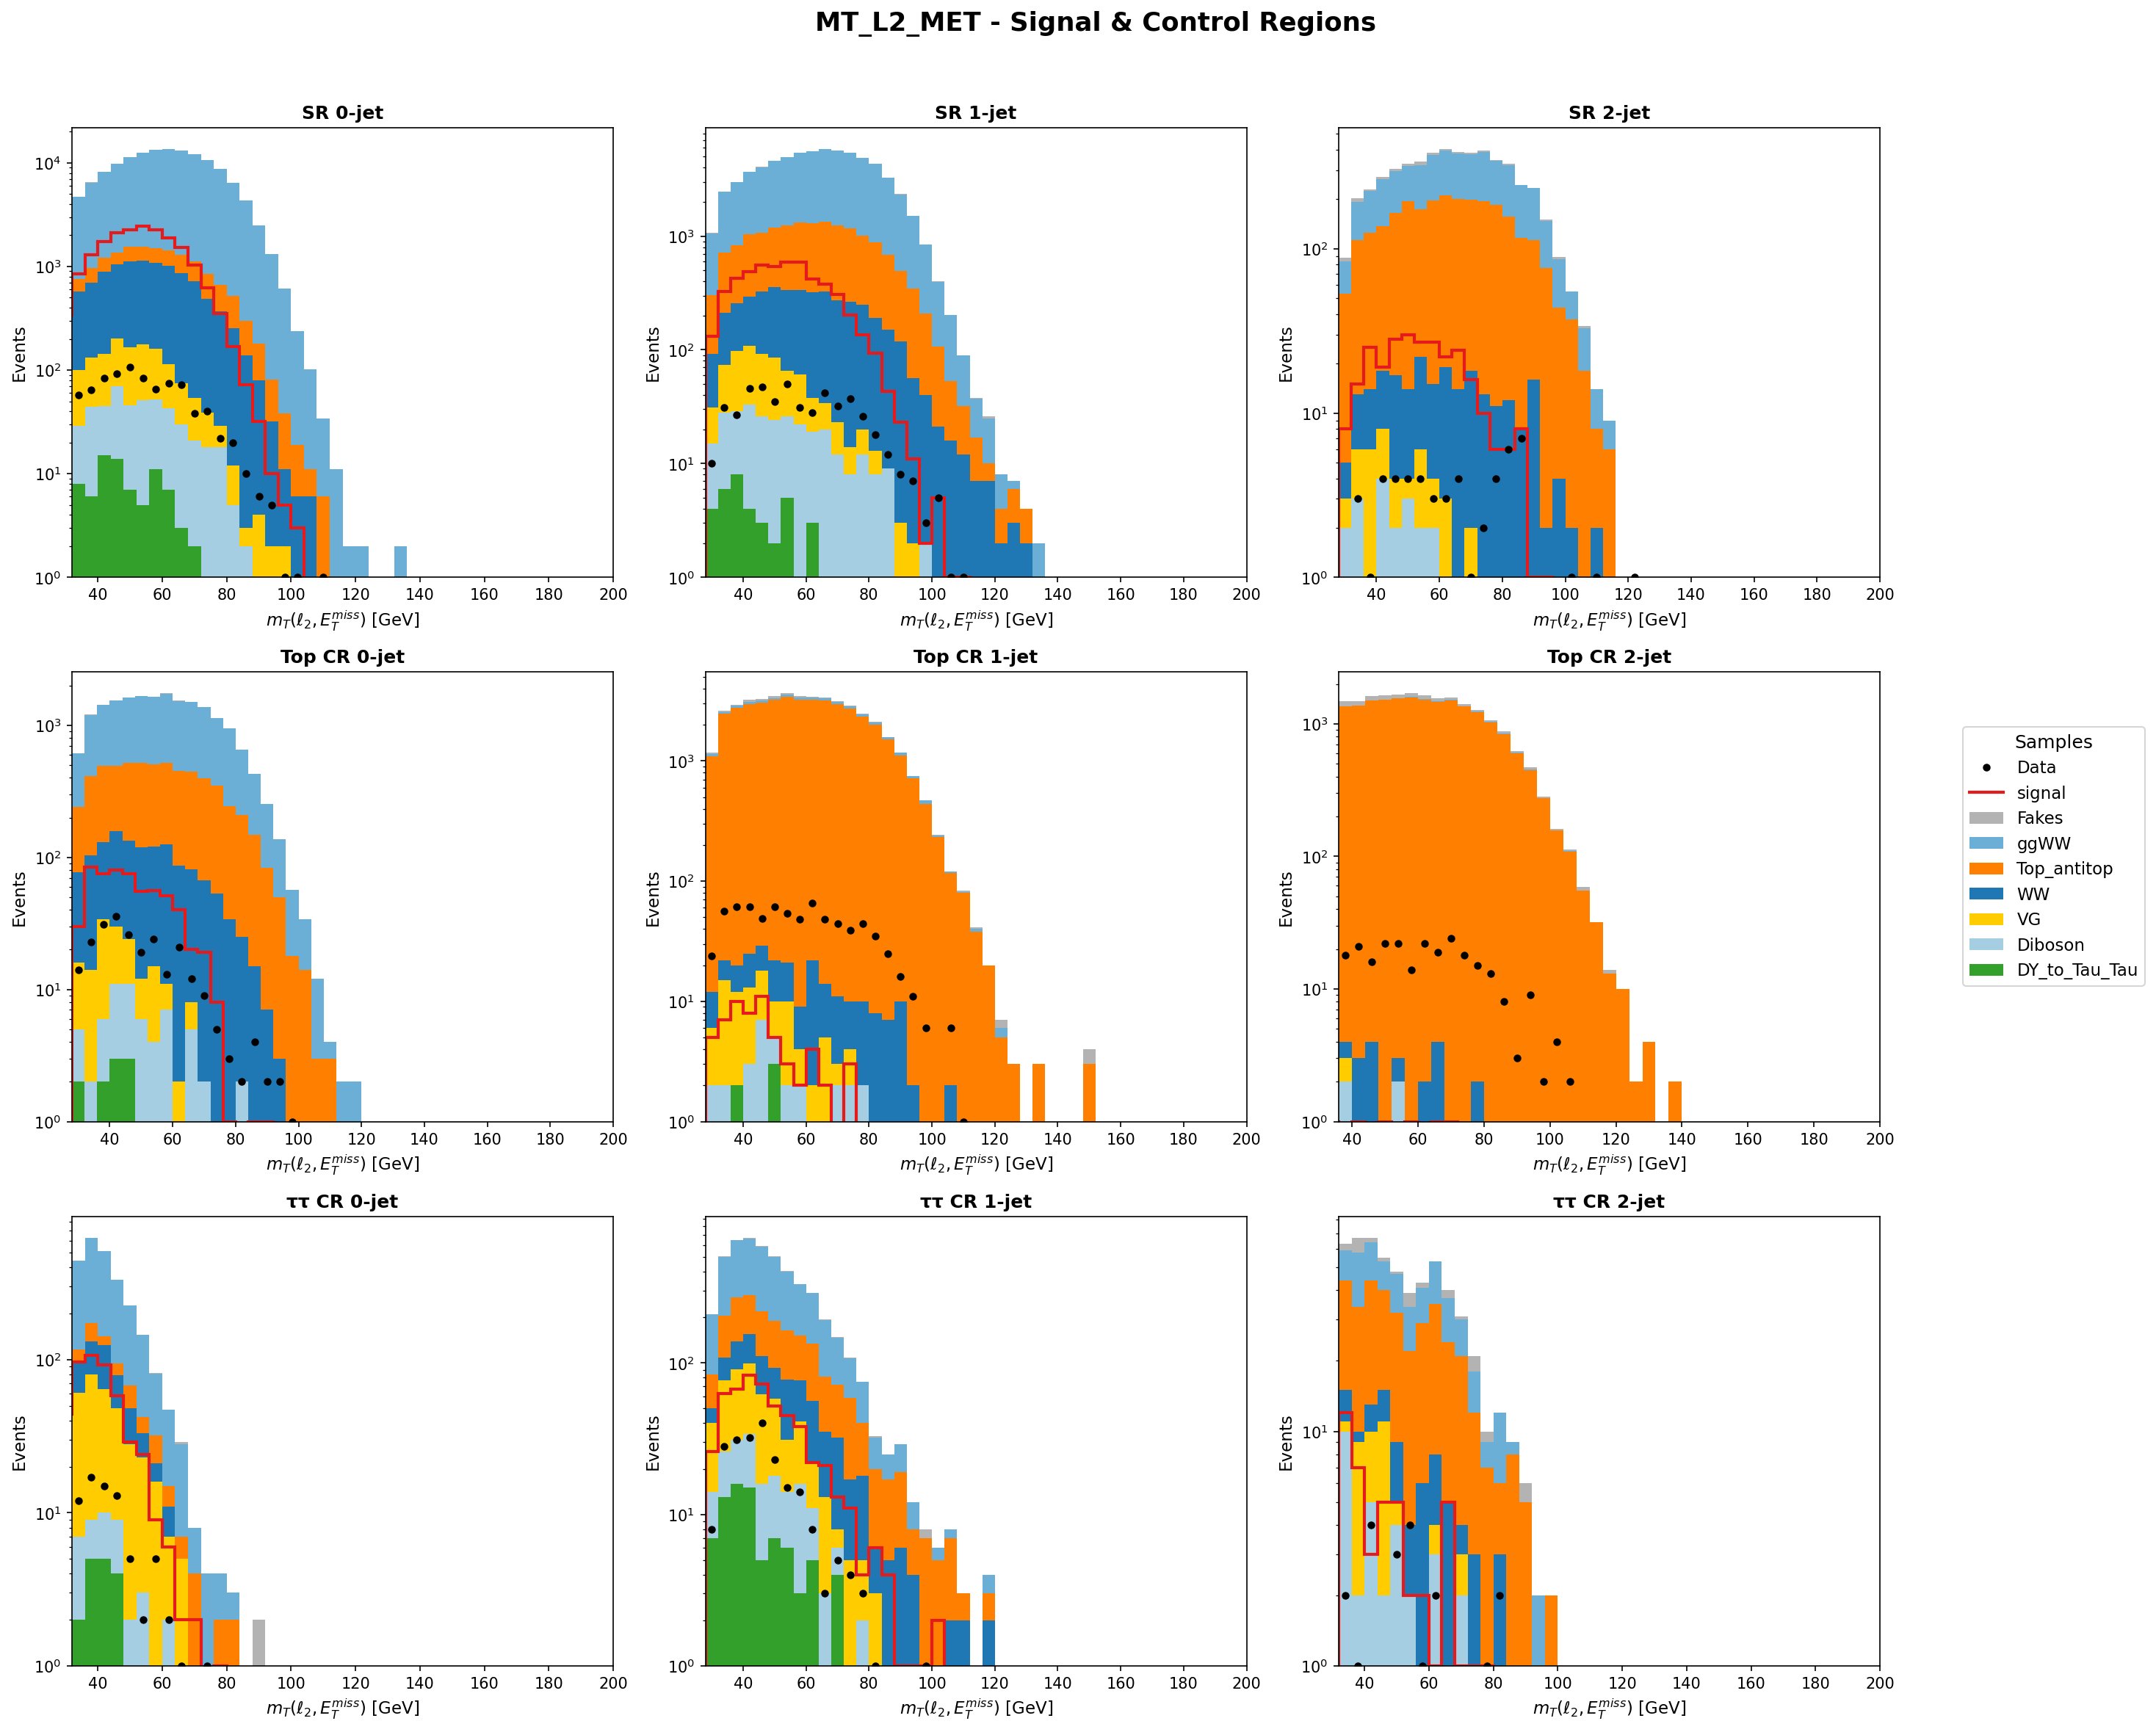

Plotting mjj...


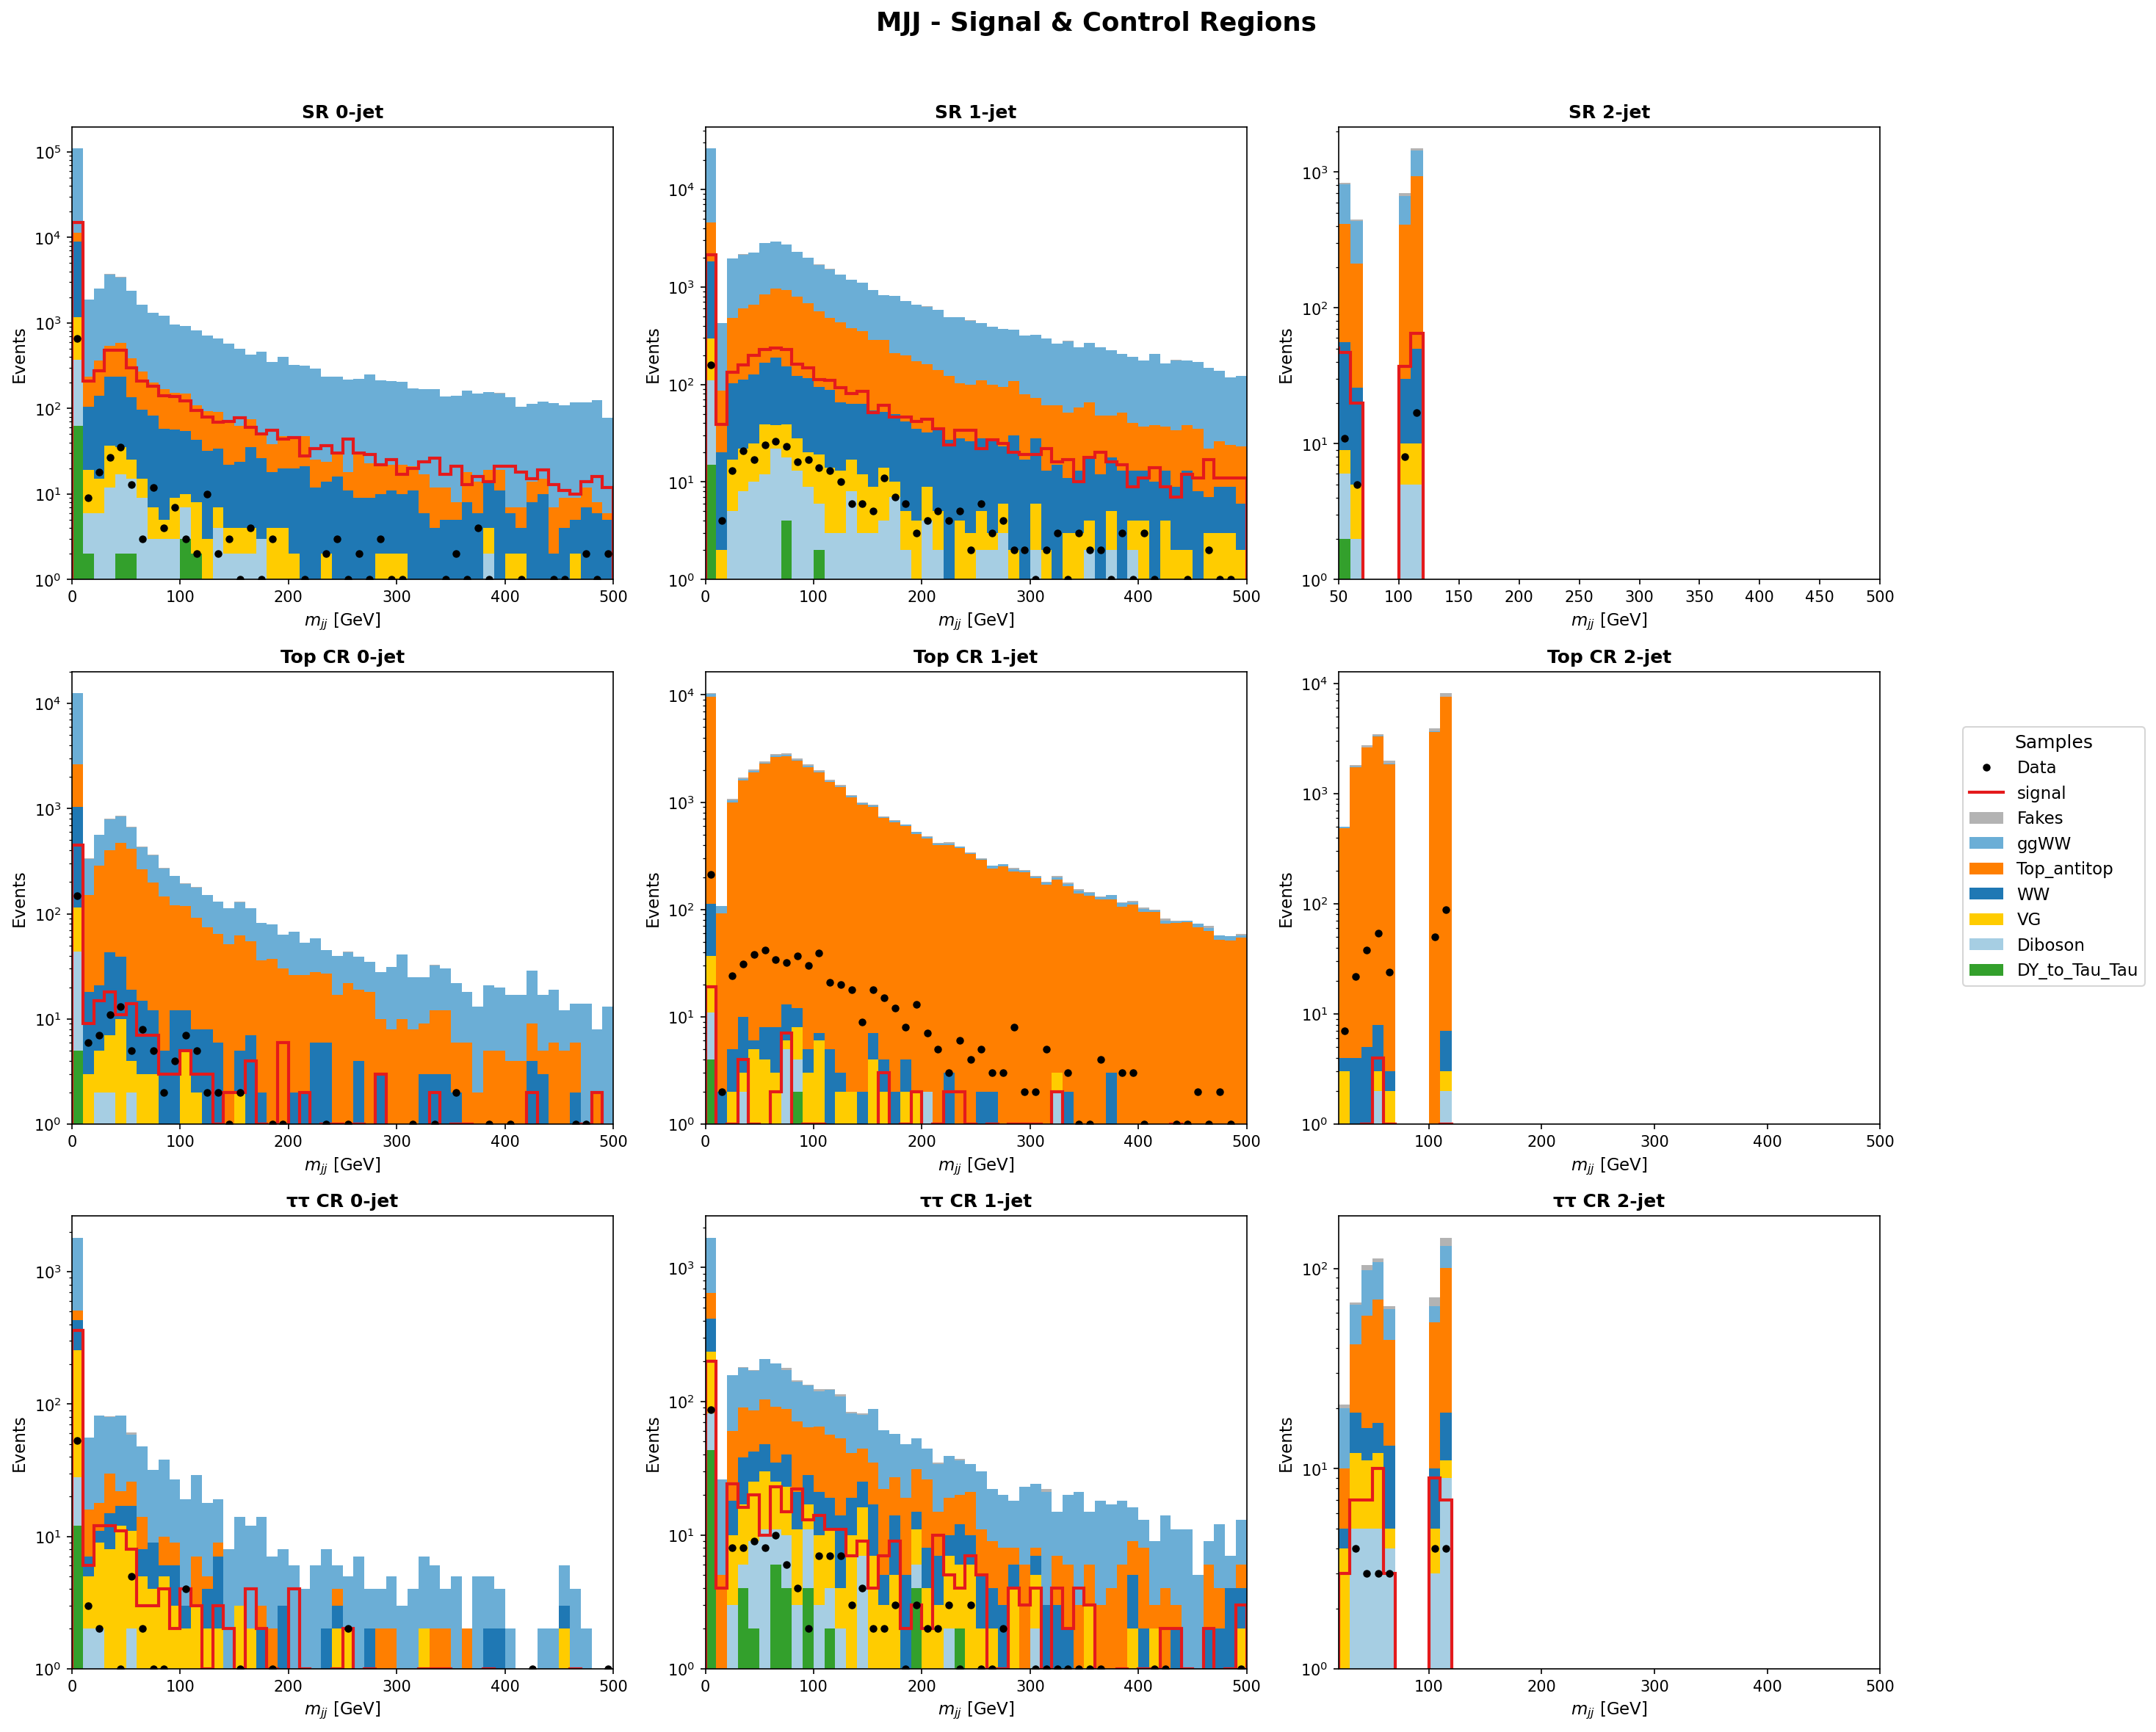

In [246]:
print("\n" + "="*60)
print("Creating stacked histogram plots...")
print("="*60)

for var_name, var_props in variables_to_plot.items():
    print(f"Plotting {var_name}...")
    fig = plot_sr_cr_stacked(var_name, var_props, hist_data_final)
    plt.show()